In [983]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss
import datetime
import folium

# Introduction

This project aims at identifying the factors leading to a collision with an injury as opposed to a collision with property damage for the region of Seattle. The local regulation authorities will benefit enormously from such knowledge, so that they take the necessary precautions and alert the local population for high-level risks of collision.

The problem can be solved with supervised machine learning, where three classification models will be tested.

# Data Preprocessing

The original data can be found under the following [link](https://data-seattlecitygis.opendata.arcgis.com/datasets/collisions?geometry=-123.320%2C47.452%2C-121.342%2C47.776).

In [321]:
collisions = pd.read_csv("Data-Collisions.csv")

/Users/ninova/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [322]:
collisions.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [186]:
collisions.shape

(194673, 38)

In [187]:
collisions.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [188]:
collisions.isnull().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE            1926
INTKEY            129603
LOCATION            2677
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SDOTCOLNUM         79737
SPEEDING          185340
ST_COLCODE            18
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

- the original data contains 37 features;
- our target is SEVERITY;
- many of the features:
    - are irrelevant to the problem;
    - contain overlapping information with other features;
- some features have wrong data type;
- many of the features have missing or NaN values.

- The data is first cleaned from irrelevant features. These include internal indentification keys of the collision/report such as the identification number ('OBJECTID'), its status ('STATUS'), report number ('REPORTNO') and keys for the accident ('INCKEY', 'COLDETKEY'). In addition, there are the keys of the intersection ('INTKEY'), lane segment ('SEGLANEKEY') and crosswalk ('CROSSWALKKEY'). The accident location is provided both with the GPS coordinates via 'X' and 'Y' as with the 'LOCATION' feature. The latter is just a more detailed description, so more difficult to use in the model and will be dropped.
 
- All remaining keys will be review for their relevance and prepared for use in the classification model.

In [323]:
collisions.drop(columns=['OBJECTID', 'STATUS', 'REPORTNO', 'INCKEY', 'COLDETKEY', 'INTKEY',
                         'SEGLANEKEY', 'CROSSWALKKEY', 'LOCATION'], axis=1, inplace=True)

- remove all records, which do not have enough information (NEI), stored in the EXCEPTRSNCODE feature;
- drop this feature together with the description of this feature.

In [324]:
collisions = collisions[collisions['EXCEPTRSNCODE'] != "NEI"]
collisions.drop(columns=['EXCEPTRSNCODE', 'EXCEPTRSNDESC'], axis=1, inplace=True)

- SEVERITYCODE and SEVERITYCODE.1 contain the same information, so the latter is dropped;
- SEVERITY description offers the same information as SEVERITY, so it will also be dropped.

In [325]:
collisions.drop(columns=['SEVERITYCODE.1', 'SEVERITYDESC'], axis=1, inplace=True)

In [326]:
collisions.columns.values

array(['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'HITPARKEDCAR'], dtype=object)

- rename the remaining columns to more easily readable labels

In [327]:
collisions.rename(
    columns={"SEVERITYCODE": "severity", 
             "X": "longitude", 
             "Y": "latitude",
             "ADDRTYPE": "address-type", 
             "COLLISIONTYPE": "collision-type",
             "PERSONCOUNT": "persons",
             "PEDCOUNT": "pedestrians",
             "PEDCYLCOUNT": "cyclists",
             "VEHCOUNT": "vehicles",
             "PEDROWNOTGRNT": "pedestrian-row",
             "INCDATE": "date", 
             "INCDTTM": "date-time",
             "JUNCTIONTYPE": "junction-type", 
             "INATTENTIONIND": "inattention", 
             "UNDERINFL": "under-influence", 
             "WEATHER": "weather", 
             "ROADCOND": "road-condition",
             "LIGHTCOND": "illumination", 
             "SPEEDING": "speeding",
             "SDOT_COLDESC": "SDOT-description", 
             "SDOT_COLCODE": "SDOT-code",
             "ST_COLDESC": "state-description", 
             "ST_COLCODE": "state-code",
             "HITPARKEDCAR": "hit-parked-car"}, inplace=True)

In [328]:
collisions['inattention'].unique()

array([nan, 'Y'], dtype=object)

In [329]:
collisions['speeding'].unique()

array([nan, 'Y'], dtype=object)

In [330]:
collisions['pedestrian-row'].unique()

array([nan, 'Y'], dtype=object)

- "inattention", "speeding" and "pedestrian-row" features are filled only when "Yes". The missing "No" values are filled in to substitute the NaN ones. All values are turned into binary.

In [331]:
collisions[['inattention', 
            'speeding', 'pedestrian-row']] = collisions[['inattention', 
                                                         'speeding', 'pedestrian-row']].fillna(0)
collisions['inattention'] = collisions['speeding'].replace(to_replace="Y", value=1)
collisions['speeding'] = collisions['speeding'].replace(to_replace="Y", value=1)
collisions['pedestrian-row'] = collisions['pedestrian-row'].replace(to_replace="Y", value=1)

- The "under-influence" feature contains both "N/Y", "0/1" and NaN values. There are unified only to numerical binary values. The NaN is substituted with 0, assuming it is not condisidered that the person was under influence.

In [332]:
collisions['under-influence'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [333]:
collisions[['under-influence']] = collisions[['under-influence']].fillna(0)
collisions['under-influence'] = collisions['under-influence'].replace(to_replace="Y", value=1)
collisions['under-influence'] = collisions['under-influence'].replace(to_replace="N", value=0)
collisions['under-influence'] = collisions['under-influence'].astype(int)

- The type of the columns "hour-of-day" and "day-of-year" are corrected.

In [334]:
collisions[['date']] = collisions[['date']].astype('datetime64')
collisions[['date-time']] = collisions[['date-time']].astype('datetime64')

In [335]:
collisions.head()

,severity,longitude,latitude,address-type,collision-type,persons,pedestrians,cyclists,vehicles,date,...,under-influence,weather,road-condition,illumination,pedestrian-row,SDOTCOLNUM,speeding,state-code,state-description,hit-parked-car
0,2,-122.323148,47.703140,Intersection,Angles,2,0,0,2,2013-03-27,...,0,Overcast,Wet,Daylight,0,NaN,0,10,Entering at angle,N
1,1,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,2006-12-20,...,0,Raining,Wet,Dark - Street Lights On,0,6354039.0,0,11,From same direction - both going straight - bo...,N
2,1,-122.334540,47.607871,Block,Parked Car,4,0,0,3,2004-11-18,...,0,Overcast,Dry,Daylight,0,4323031.0,0,32,One parked--one moving,N
3,1,-122.334803,47.604803,Block,Other,3,0,0,3,2013-03-29,...,0,Clear,Dry,Daylight,0,NaN,0,23,From same direction - all others,N
4,2,-122.306426,47.545739,Intersection,Angles,2,0,0,2,2004-01-28,...,0,Raining,Wet,Daylight,0,4028032.0,0,10,Entering at angle,N


- drop all duplicates

In [336]:
collisions.drop_duplicates(inplace=True)

- The data is strongly imbalanced towards collisions with severity 1, as opposed to 2.

In [337]:
sev1 = collisions['severity'][collisions['severity']==1].count()
sev2 = collisions['severity'][collisions['severity']==2].count()
print(sev1, sev2)

131348 57666


# Exploratory Data Analysis
In the next section, I am going to get familiar with the data by looking at specific features and try to answer the following questions. Can any information be extracted about the severity of a collision from the time of day/season/year? How do the weather, road or street illumination conditions affect the accident severity? Can reckless driving be an important factor? Can looking at a collision in hindsight help prevent future accidents?

## Accident severity vs Time of Day, Month, Year
The next subsection explores how is there is any significant differences as a function of time of the day, month, year, between accidents with injuries and accudents with only property damage.

In [338]:
# extract the time and date in several ways, so as to facilitate the plotting
collisions.insert(9, 'year', collisions['date'].dt.year)
collisions.insert(10, 'month', collisions['date'].dt.month)
collisions.insert(11, 'day-of-week', collisions['date'].dt.dayofweek)
collisions.insert(12, 'hour', collisions['date-time'].dt.hour)
collisions.insert(13, 'time-of-day', collisions['date-time'].dt.time)

# Records without an exact time are dropped. For consistency, all time plots is done with the same data frame.
nohour = pd.to_datetime('00:00:00').time()
collisions = collisions[collisions['time-of-day'] != nohour]

# remove the original columns
collisions.drop(columns=["date", "date-time"], inplace=True)

In [339]:
collisions.head()

,severity,longitude,latitude,address-type,collision-type,persons,pedestrians,cyclists,vehicles,year,...,under-influence,weather,road-condition,illumination,pedestrian-row,SDOTCOLNUM,speeding,state-code,state-description,hit-parked-car
0,2,-122.323148,47.703140,Intersection,Angles,2,0,0,2,2013,...,0,Overcast,Wet,Daylight,0,NaN,0,10,Entering at angle,N
1,1,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,2006,...,0,Raining,Wet,Dark - Street Lights On,0,6354039.0,0,11,From same direction - both going straight - bo...,N
2,1,-122.334540,47.607871,Block,Parked Car,4,0,0,3,2004,...,0,Overcast,Dry,Daylight,0,4323031.0,0,32,One parked--one moving,N
3,1,-122.334803,47.604803,Block,Other,3,0,0,3,2013,...,0,Clear,Dry,Daylight,0,NaN,0,23,From same direction - all others,N
4,2,-122.306426,47.545739,Intersection,Angles,2,0,0,2,2004,...,0,Raining,Wet,Daylight,0,4028032.0,0,10,Entering at angle,N


- let's look at how each of these columns correlates with the accident severity

In [340]:
hour = collisions[['severity', 'hour']].groupby(by=['severity', 'hour']).size().unstack(level=1)

# normalize per row
hour.iloc[:,:] = Normalizer(norm='l1').fit_transform(hour)
hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
severity,,,,,,,,,,,,,,,,,,,,,
1,0.026430,0.022834,0.024205,0.011531,0.008453,0.010341,0.018958,0.038260,0.051198,0.049373,...,0.063637,0.068040,0.071154,0.073733,0.055611,0.043472,0.039068,0.034719,0.034619,0.030706
2,0.017493,0.016683,0.017513,0.007026,0.005467,0.009799,0.020429,0.043085,0.053998,0.048288,...,0.067705,0.075236,0.080561,0.090280,0.066935,0.045899,0.035249,0.032536,0.030572,0.022393


<IPython.core.display.Javascript object>


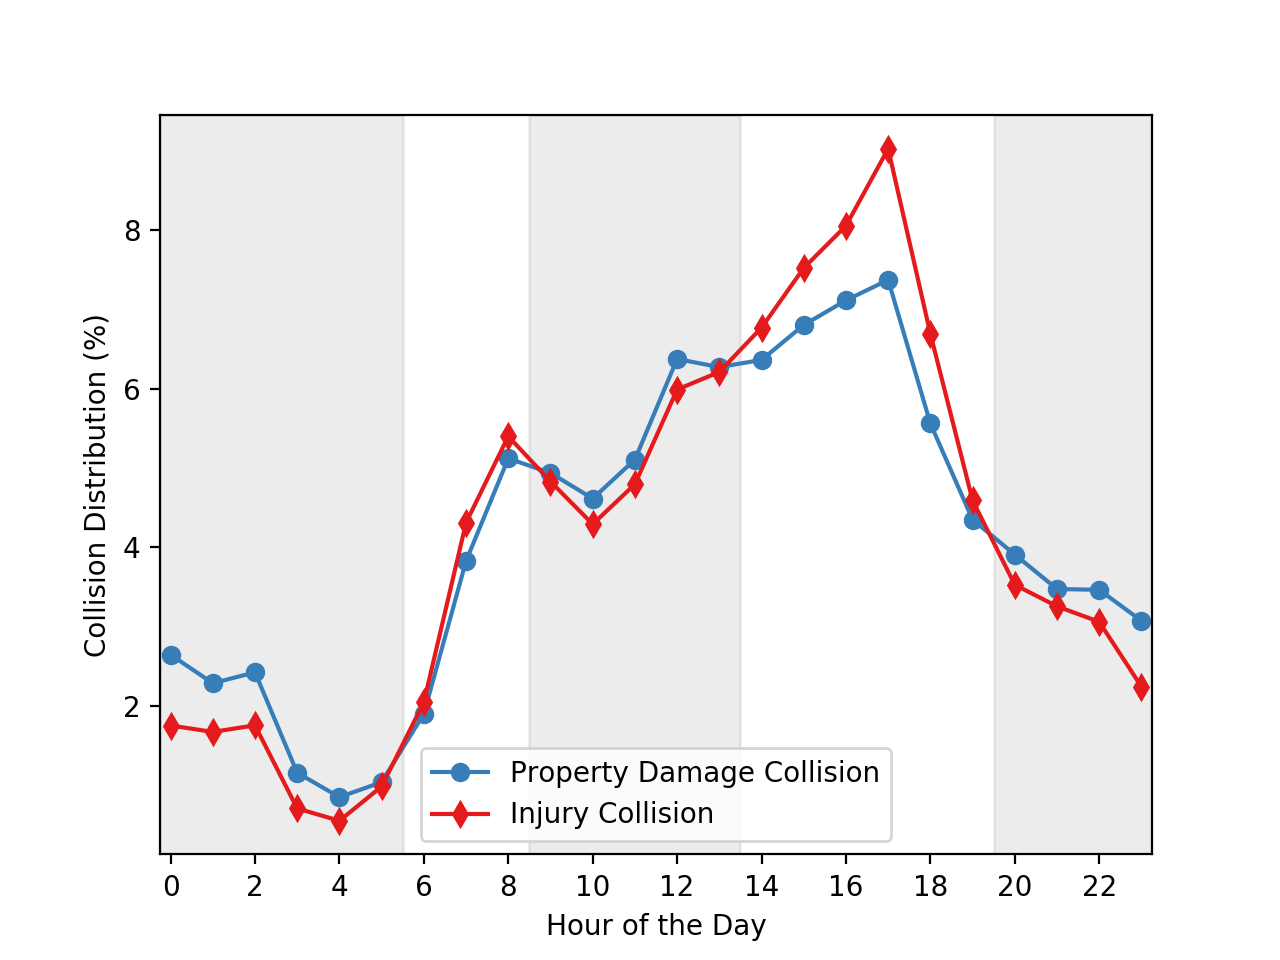

In [341]:
# plot the results
%matplotlib notebook

plt.axvspan(-0.25, 5.5, alpha=0.15, color='grey')
plt.axvspan(8.5, 13.5, alpha=0.15, color='grey')
plt.axvspan(19.5, 23.25, alpha=0.15, color='grey')

plt.plot(hour.columns.values, hour.iloc[0, :].values*100, marker='o', color="#377eb8", label="Property Damage Collision")
plt.plot(hour.columns.values, hour.iloc[1, :].values*100, marker='d', color="#e41a1c", label="Injury Collision")

plt.xlabel("Hour of the Day")
plt.ylabel("Collision Distribution (%)")

plt.xticks(np.arange(0, 24, 2))
plt.xlim(-0.25, 23.25)

plt.legend()
plt.savefig("Report/Collisions_vs_Hour.png", dpi=300)
plt.show()

The percentage of collisions with injury are distributed in such a way, as to be higher during peak hours and lower in the evening/night time range. The data will be adjusted to have four classes, in agreement with the sections in the figure above.

In [342]:
collisions['hour']= np.select(condlist=[(collisions['hour']>5.5) & (collisions['hour']<8.5),
                                        (collisions['hour']>8.5) & (collisions['hour']<13.5),
                                        (collisions['hour']>13.5) & (collisions['hour']<19.5),
                                        (collisions['hour']>19.5) | (collisions['hour']<5.5)],
                              choicelist=[0, 1, 2, 3])
collisions['hour'].unique()

array([2, 1, 0, 3])

- let's have a look at the dependence on the day of week.

In [343]:
week = collisions[['severity', 'day-of-week']].groupby(by=['severity', 'day-of-week']).size().unstack(level=1)

# normalize per row
week.iloc[:,:] = Normalizer(norm='l1').fit_transform(week)
week

day-of-week,0,1,2,3,4,5,6
severity,,,,,,,
1,0.134046,0.145132,0.146639,0.147683,0.165915,0.142962,0.117622
2,0.138021,0.149845,0.151526,0.154846,0.163674,0.137393,0.104695


<IPython.core.display.Javascript object>


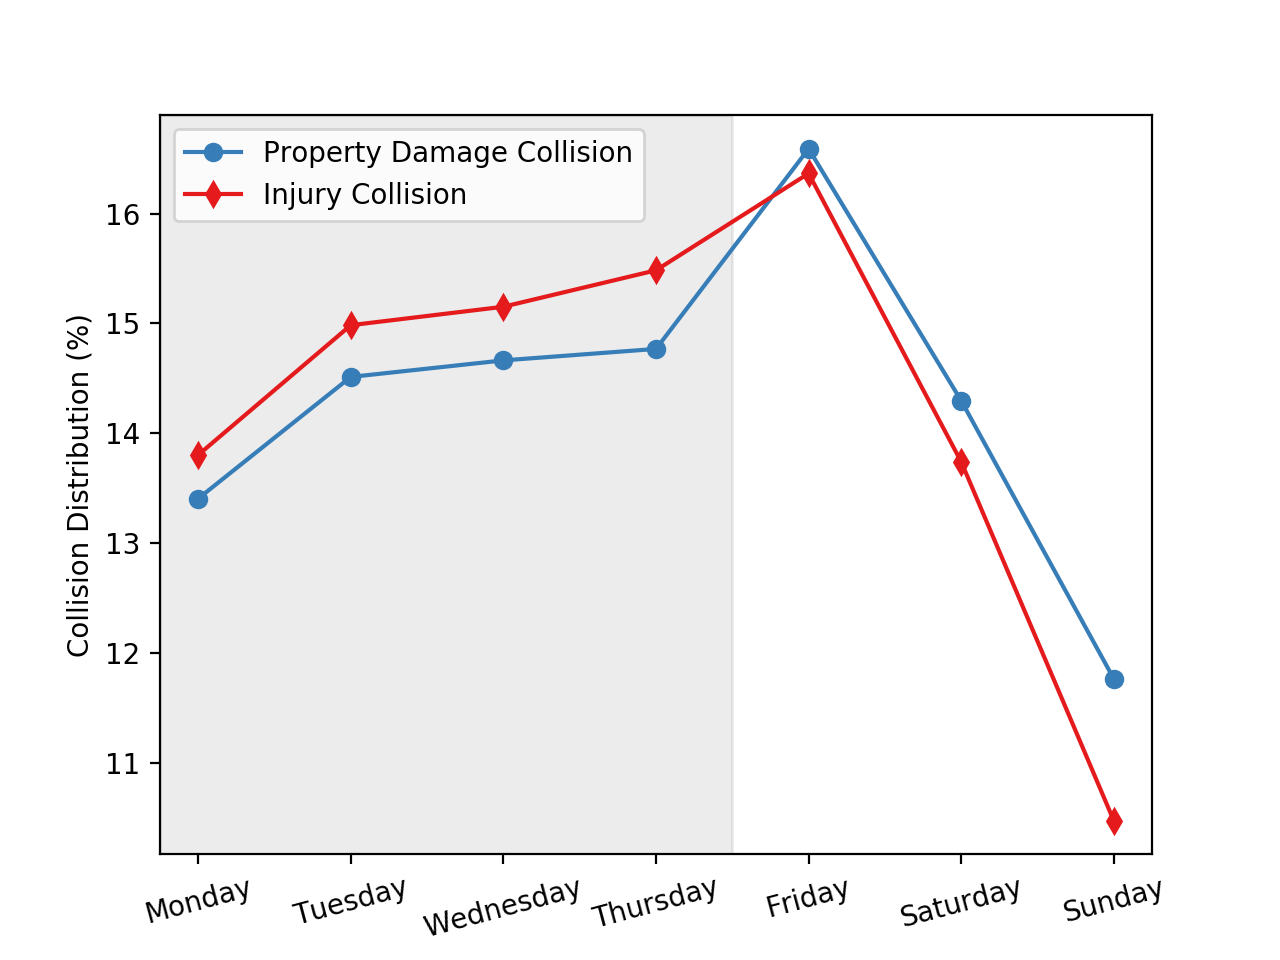

In [344]:
# plot the results
%matplotlib notebook

plt.axvspan(-0.25, 3.5, alpha=0.15, color='grey')

plt.plot(week.columns.values, week.iloc[0, :].values*100, marker='o', 
         color="#377eb8", label="Property Damage Collision")
plt.plot(week.columns.values, week.iloc[1, :].values*100, marker='d', 
         color="#e41a1c", label="Injury Collision")

plt.ylabel("Collision Distribution (%)")

plt.xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=15)
plt.xlim(-0.25, 6.25)

plt.legend()
plt.savefig("Report/Collisions_vs_Week.png", dpi=300)
plt.show()

The number of collisions with injury are found to appear more during the week until Friday in proportion to the weekend.

In [345]:
collisions['day-of-week']= np.select(condlist=[(collisions['day-of-week']<3.5),
                                               (collisions['day-of-week']>3.5)],
                                     choicelist=[0, 1])
collisions['day-of-week'].unique()

array([0, 1])

- Can the month of the year tell us something about the severity of an accident?

In [346]:
month = collisions[['severity', 'month']].groupby(by=['severity', 'month']).size().unstack(level=1)

# normalize per row
month.iloc[:,:] = Normalizer(norm='l1').fit_transform(month)
month

month,1,2,3,4,5,6,7,8,9,10,11,12
severity,,,,,,,,,,,,
1,0.086190,0.073197,0.085300,0.081432,0.084110,0.085708,0.083221,0.080824,0.082195,0.090411,0.084882,0.082531
2,0.080642,0.066753,0.082647,0.082323,0.089207,0.084631,0.090340,0.087729,0.083335,0.094167,0.082849,0.075378


<IPython.core.display.Javascript object>


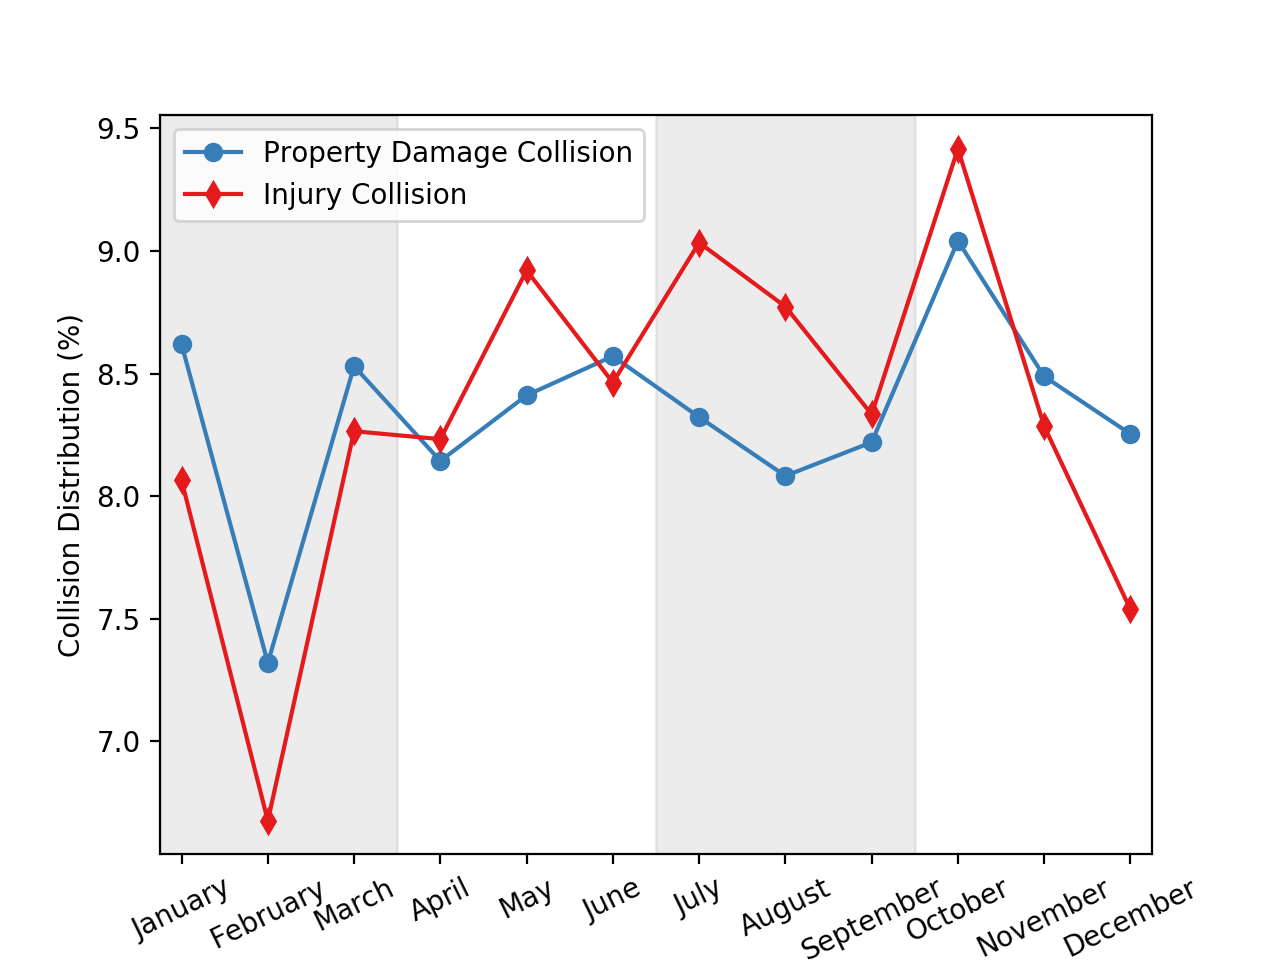

In [347]:
# plot the results
%matplotlib notebook

plt.axvspan(0.75, 3.5, alpha=0.15, color='grey')
plt.axvspan(6.5, 9.5, alpha=0.15, color='grey')

plt.plot(month.columns.values, month.iloc[0, :].values*100, marker='o', 
         color="#377eb8", label="Property Damage Collision")
plt.plot(month.columns.values, month.iloc[1, :].values*100, marker='d', 
         color="#e41a1c", label="Injury Collision")

plt.ylabel("Collision Distribution (%)")

plt.xticks(np.arange(1, 13, 1), 
           ["January", "February", "March", "April", "May", "June", 
            "July", "August", "September", "October", "November", "December"], rotation=26)
plt.xlim(0.75, 12.25)

plt.legend()
plt.savefig("Report/Collisions_vs_Month.png", dpi=300)
plt.show()

It seems that in proportion, more collision injuries happen during the colder months, November-March. A new feature reflecting this will be created with two classes.

In [348]:
collisions['cold-months']= np.select(condlist=[(collisions['month']<3.5) | (collisions['month']>10.5),
                                               (collisions['month']>3.5) & (collisions['month']<10.5)],
                                     choicelist=[0, 1])
collisions.drop(columns=["month"], inplace=True)
collisions['cold-months'].unique()

array([0, 1])

- What changes are there over the year?

<IPython.core.display.Javascript object>


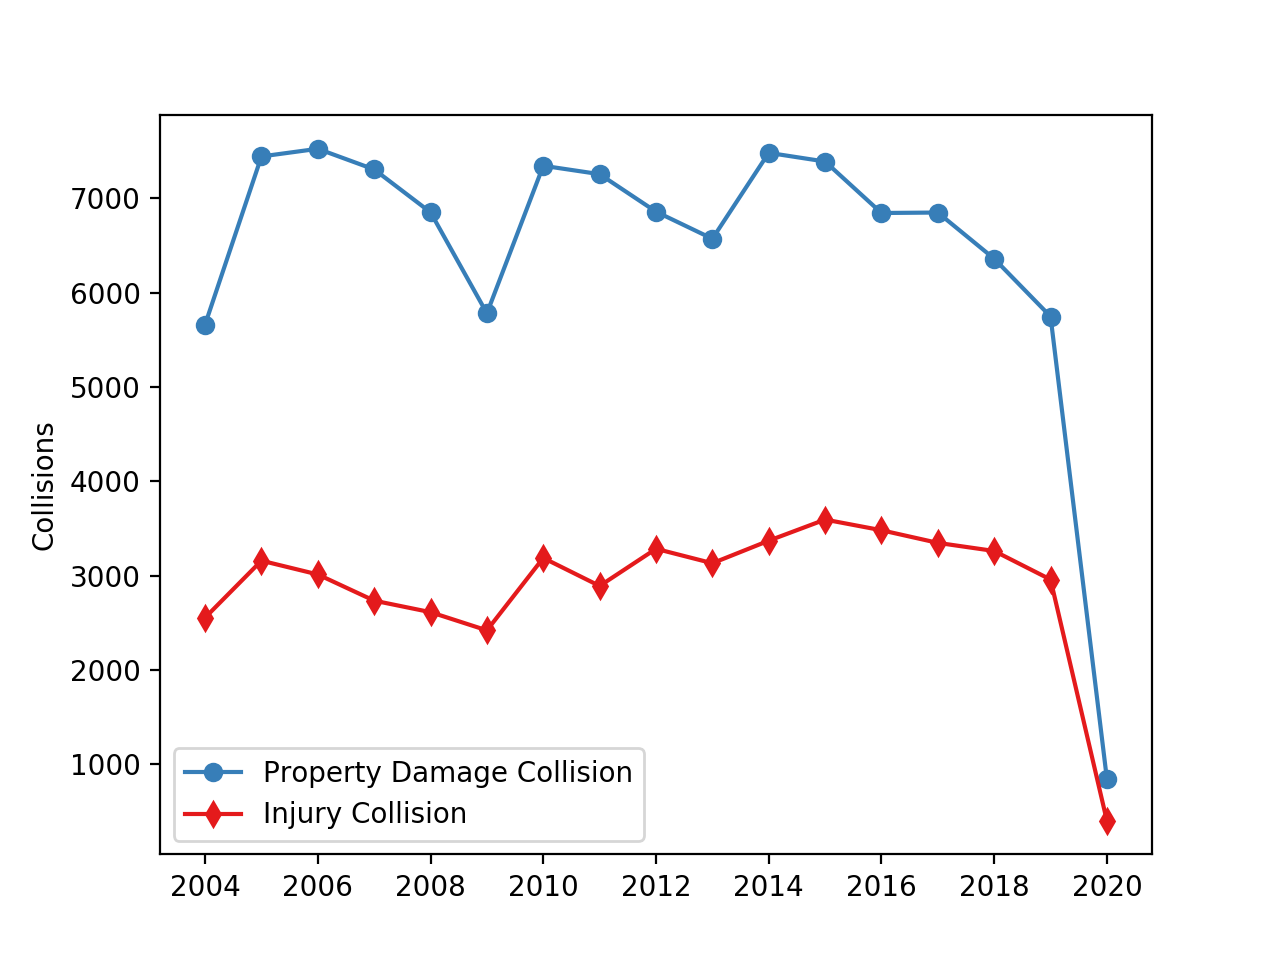

In [349]:
year = collisions[['severity', 'year']].groupby(by=['severity', 'year']).size().unstack(level=1)

# plot the results
%matplotlib notebook

plt.plot(year.columns.values, year.iloc[0, :].values, marker='o', 
         color="#377eb8", label="Property Damage Collision")
plt.plot(year.columns.values, year.iloc[1, :].values, marker='d', 
         color="#e41a1c", label="Injury Collision")

plt.ylabel("Collisions")

plt.legend()
plt.savefig("Report/Collisions_vs_Year.png", dpi=300)
plt.show()

The year range goes from 2004 to 2020. 2020 is however still ongoing and covers data until April, which can account for the artificial drop in number accidents. In addition, the last months coincide with the COVID-19 emergency and lockdown, so fewer cars than normal were in the traffic and thus fewer accidents were reported. Since the aim is to predict the severity of collisions under normal circumstances, no accidents from 2020 were considered in this report.

In [351]:
collisions = collisions[collisions['year'] != 2020]
year.drop(columns=2020, axis=1, inplace=True)
collisions.head()

,severity,longitude,latitude,address-type,collision-type,persons,pedestrians,cyclists,vehicles,year,...,weather,road-condition,illumination,pedestrian-row,SDOTCOLNUM,speeding,state-code,state-description,hit-parked-car,cold-months
0,2,-122.323148,47.703140,Intersection,Angles,2,0,0,2,2013,...,Overcast,Wet,Daylight,0,NaN,0,10,Entering at angle,N,0
1,1,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,2006,...,Raining,Wet,Dark - Street Lights On,0,6354039.0,0,11,From same direction - both going straight - bo...,N,0
2,1,-122.334540,47.607871,Block,Parked Car,4,0,0,3,2004,...,Overcast,Dry,Daylight,0,4323031.0,0,32,One parked--one moving,N,0
3,1,-122.334803,47.604803,Block,Other,3,0,0,3,2013,...,Clear,Dry,Daylight,0,NaN,0,23,From same direction - all others,N,0
4,2,-122.306426,47.545739,Intersection,Angles,2,0,0,2,2004,...,Raining,Wet,Daylight,0,4028032.0,0,10,Entering at angle,N,0


- Let's see if regression can be used to predict the number of collisions.

<IPython.core.display.Javascript object>


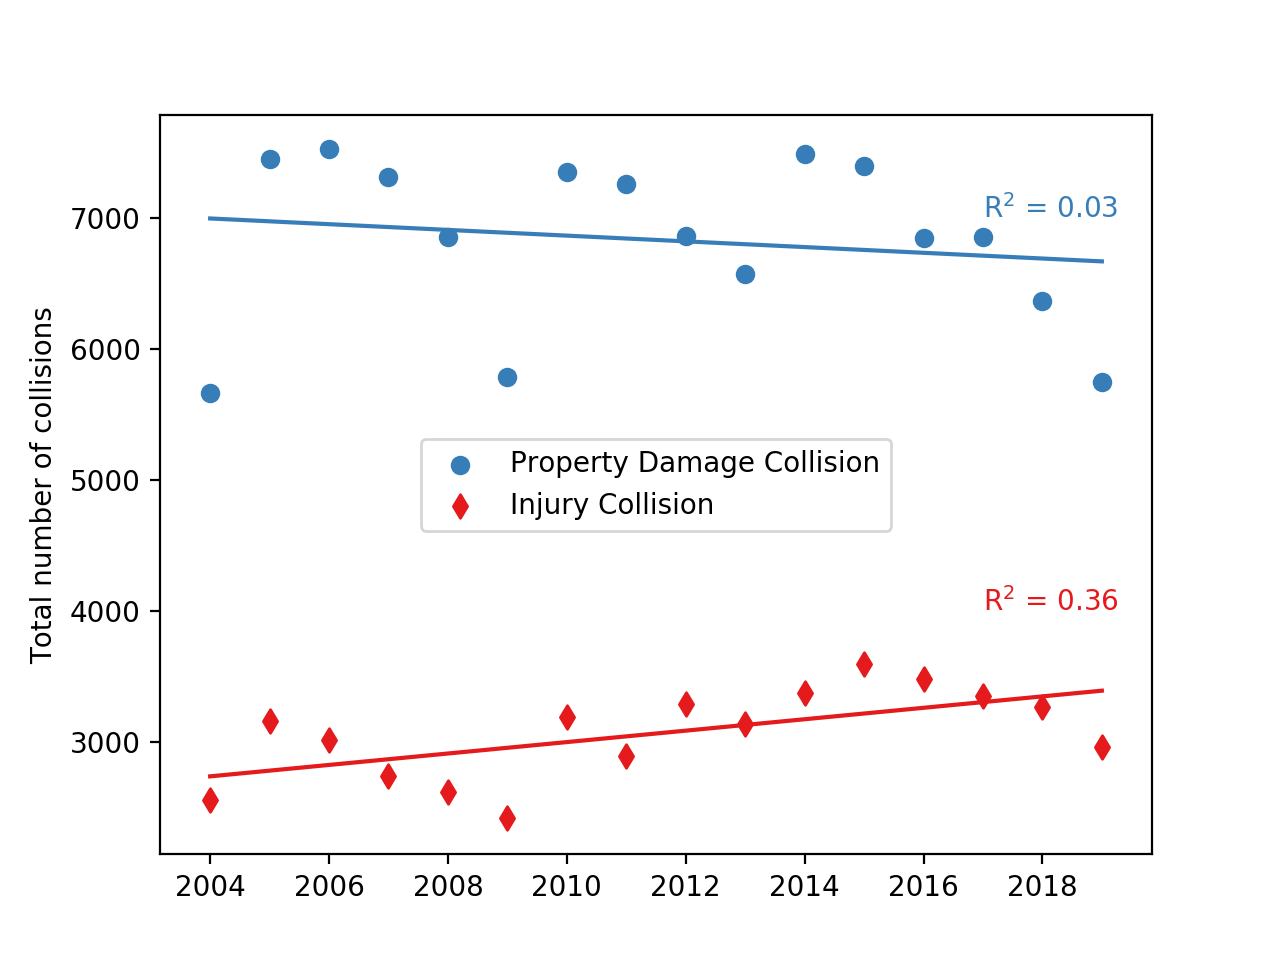

In [352]:
%matplotlib notebook
# fit the data
s0, i0 = np.polyfit(year.columns.values, year.iloc[0, :].values, 1)
s1, i1 = np.polyfit(year.columns.values, year.iloc[1, :].values, 1)
x = year.columns.values

def lin_eq(x, s, i):
    return s*x+i

# calculate the coefficient of determination
r2_1 = r2_score(year.iloc[0, :].values, lin_eq(x, s0, i0))
r2_2 = r2_score(year.iloc[1, :].values, lin_eq(x, s1, i1))

# plot
plt.figure()

plt.scatter(x, year.iloc[0, :].values, marker='o', 
         color="#377eb8", label="Property Damage Collision")
plt.scatter(x, year.iloc[1, :].values, marker='d', 
         color="#e41a1c", label="Injury Collision")

plt.plot(x, lin_eq(x, s0, i0), color="#377eb8")
plt.plot(x, lin_eq(x, s1, i1), color="#e41a1c")

plt.text(2017, 7000, r"R$^2$ = %.2f" %r2_1, color="#377eb8")
plt.text(2017, 4000, r"R$^2$ = %.2f" %r2_2, color="#e41a1c")

plt.ylabel("Total number of collisions")

plt.legend(loc='center')
plt.savefig("Report/Collisions_vs_Year2.png", dpi=300)
plt.show()

The number of accidents over the years has been varying. As it can be seen in the graph above, several drops have been observed (2004, 2009, 2013, 2019) with the number of case going back up again in the following year. Fitting a line over the collisions yield very poor results - the coefficient of determination (R$^2$) is close to 0 for property-damage accidents and at 0.36 for collisions with injuries. This can be an indication that more complex factors are at play which affect so significantly the number of accidents. Interestingly though, the injury collisions seem to increase with time, as opposed to the property-damage ones.

## Collision severity and the weather conditions
How do the weather conditions affect the severity of a collision?

In [353]:
collisions['weather'].unique()

array(['Overcast', 'Raining', 'Clear', 'Unknown', 'Other', 'Snowing', nan,
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind'], dtype=object)

In [354]:
weather = collisions[['severity', 'weather']].groupby(by=['severity', 'weather']).size().unstack(level=1)
# normalize per row
weather.iloc[:,:] = Normalizer(norm='l1').fit_transform(weather)
weather

weather,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,Overcast,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown
severity,,,,,,,,,,
1,0.000284,0.581516,0.003105,0.004681,0.145455,0.169929,0.000156,0.000586,0.005477,0.088812
2,0.000266,0.633538,0.003474,0.001696,0.151121,0.193989,0.000143,0.000450,0.002881,0.012444


The weather feature contains 10 categories. Considering that three of them are well below 1%, these will be merged with other classes. The "Sleet/Hail/Freezing Rain" can be united with "Rain", because of the similar weather conditions. "blowing sand/dirt" and "Severe Crosswind" are moved to "Other".

One of the classes is labelled as "unknown". If it is not noted, it could be probable that the weather was clear with no particular phenomena. Given however this uncertainty, records with this value will be removed from the data set along with any NaN values.

The remaining categories cover both clear and overcast sky, as well as reduced visibility during rain, snow or fog.

Interestingly, most accidents are found to happen when the weather is clear. Next come accidents during rain, followed by collisions with overcast sky. The last could indeed include the time just before the rain comes, or just after.

In [364]:
# remove the records with NaN and Unknown
collisions = collisions[collisions['weather'] != 'Unknown']
collisions = collisions[collisions['weather'].notna()]

In [358]:
# rename the classes
collisions['weather'].replace("Blowing Sand/Dirt", "Other", inplace=True)
collisions['weather'].replace("Severe Crosswind", "Other", inplace=True)
collisions['weather'].replace("Sleet/Hail/Freezing Rain", "Raining", inplace=True)
collisions['weather'].replace("Clear", "Sunny", inplace=True)
collisions['weather'].replace("Raining", "Rain", inplace=True)
collisions['weather'].replace("Snowing", "Snow", inplace=True)

In [455]:
weather = collisions[['severity', 'weather']].groupby(by=['severity', 'weather']).size().unstack(level=1)
# normalize per row
weather.iloc[:,:] = Normalizer(norm='l1').fit_transform(weather)*100
weather = weather[['Other', 'Fog/Smog/Smoke', 'Snow', 'Overcast', 'Rain', 'Sunny',]]
weather

weather,Other,Fog/Smog/Smoke,Snow,Overcast,Rain,Sunny
severity,,,,,,
1,0.561928,0.340775,0.601132,15.963168,18.713497,63.819500
2,0.213109,0.351734,0.291732,15.302491,19.688819,64.152115


<IPython.core.display.Javascript object>


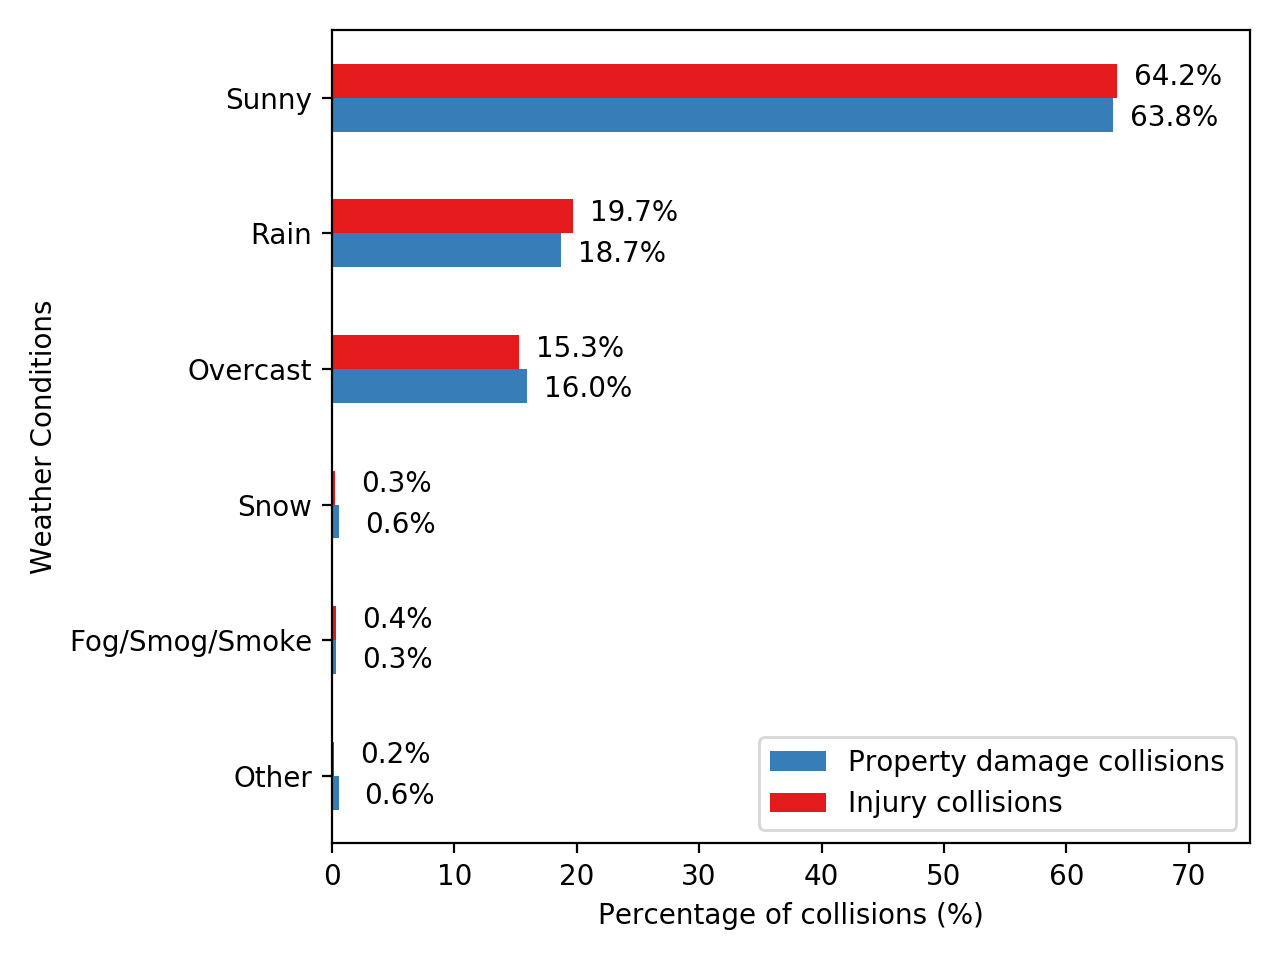

In [546]:
%matplotlib notebook

weather.T.plot(kind='barh',
               color=["#377eb8", "#e41a1c"])

for t in range(len(weather.T.index.values)):
    value1 = float(weather.T.iloc[t, 0])
    value2 = float(weather.T.iloc[t, 1])

    plt.annotate("{:.1f}%".format(value1), xy=(value1+5.0, t-0.15), ha='center', va='center')
    plt.annotate("{:.1f}%".format(value2), xy=(value2+5.0, t+0.15), ha='center', va='center')

plt.xlabel("Percentage of collisions (%)")
plt.ylabel("Weather Conditions")
plt.xlim(0, 75)
plt.legend(labels=["Property damage collisions", "Injury collisions"], loc='lower right')
plt.tight_layout()
plt.savefig("Report/Collisions_vs_Weather.png", dpi=300)
plt.show()

Interestingly, the nature of the accidents does not change significantly as a function of the weather conditions.

In [464]:
# turn all categorical values to numerical
collisions['weather'].replace(
    to_replace=["Sunny", "Rain", "Overcast", "Snow", "Fog/Smog/Smoke", "Other"], 
    value=[0, 1, 2, 3, 4, 5], inplace=True
)

## Collision severity and the road conditions
How do the road conditions affect the severity of the collision?

In [466]:
roadcond = collisions[['severity', 'road-condition']].groupby(by=['severity', 'road-condition']).size().unstack(level=1)
# normalize per row
roadcond.iloc[:,:] = Normalizer(norm='l1').fit_transform(roadcond)*100
roadcond

road-condition,Dry,Ice,Oil,Other,Sand/Mud/Dirt,Snow/Slush,Standing Water,Unknown,Wet
severity,,,,,,,,,
1,70.921815,0.761141,0.030164,0.057312,0.037202,0.629424,0.057312,0.899895,26.605735
2,71.280162,0.473904,0.039320,0.070361,0.033111,0.283515,0.051736,0.225570,27.542320


In [469]:
collisions['road-condition'].isnull().sum()

33

In [476]:
# remove the records with NaN and Unknown
collisions = collisions[collisions['road-condition'] != 'Unknown']
collisions = collisions[collisions['road-condition'].notna()]

Similar to the weather conditions, there are numerious categories for this feature. Let's group them, so as to less fragmented data.

Dry is by far the most prominent category. This is followed by collisions on wet roads and to much lesser extent all other categories. "Standing water" is unified with "Wet", since in both cases we have water on the road which affect the friction of the tyres. "Ice/snow/slush" category is created to account for the winter conditions. The presence of oil, sand, mud or dirt are less than 0.05%, so these are moved to the category "Other". 

In [477]:
# rename the classes
collisions['road-condition'].replace("Oil", "Other", inplace=True)
collisions['road-condition'].replace("Sand/Mud/Dirt", "Other", inplace=True)
collisions['road-condition'].replace("Standing Water", "Wet", inplace=True)
collisions['road-condition'].replace("Ice", "Ice/Snow/Slush", inplace=True)
collisions['road-condition'].replace("Snow/Slush", "Ice/Snow/Slush", inplace=True)

In [478]:
roadcond = collisions[['severity', 'road-condition']].groupby(by=['severity', 'road-condition']).size().unstack(level=1)
# normalize per row
roadcond.iloc[:,:] = Normalizer(norm='l1').fit_transform(roadcond)*100
roadcond

road-condition,Dry,Ice/Snow/Slush,Other,Wet
severity,,,,
1,71.565832,1.403192,0.125810,26.905165
2,71.441313,0.759131,0.143115,27.656441


In [542]:
roadcond = roadcond[['Other', 'Ice/Snow/Slush', 'Wet', 'Dry']].T

<IPython.core.display.Javascript object>


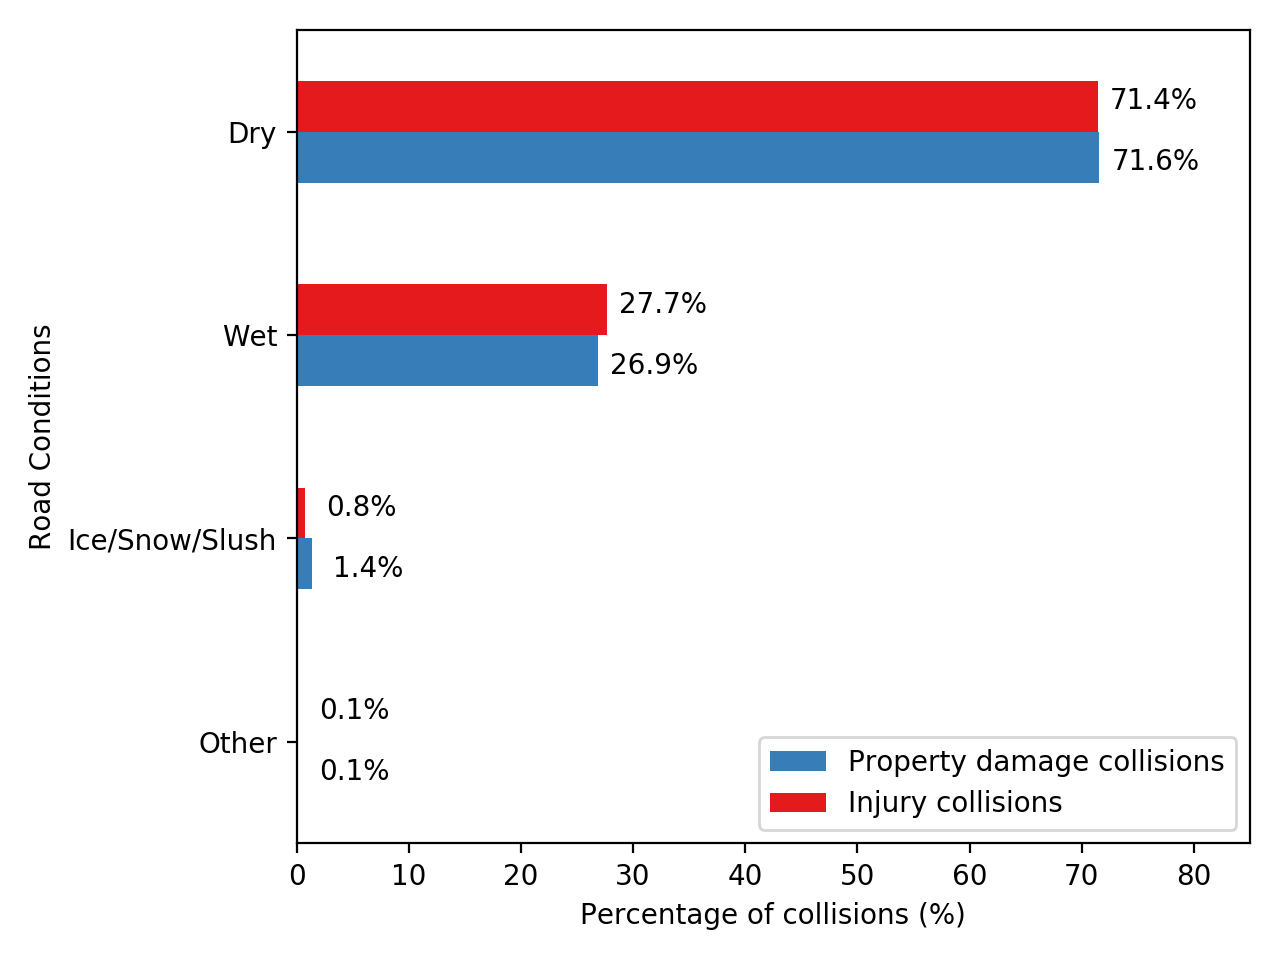

In [544]:
%matplotlib notebook

roadcond.plot(kind='barh',
               color=["#377eb8", "#e41a1c"])

for t in range(len(roadcond.index.values)):
    value1 = float(roadcond.iloc[t, 0])
    value2 = float(roadcond.iloc[t, 1])

    plt.annotate("{:.1f}%".format(value1), xy=(value1+5.0, t-0.15), ha='center', va='center')
    plt.annotate("{:.1f}%".format(value2), xy=(value2+5.0, t+0.15), ha='center', va='center')

plt.xlabel("Percentage of collisions (%)")
plt.ylabel("Road Conditions")
plt.xlim(0, 85)
plt.legend(labels=["Property damage collisions", "Injury collisions"], loc='lower right')
plt.tight_layout()
plt.savefig("Report/Collisions_vs_RoadConditions.png", dpi=300)
plt.show()

More than two-third of collisions happen on dry roads and a little less than one-third - on wet ones. In comparions, collisions on ice, snow or slush are only about 1% of all accidents.

In [483]:
# turn all categorical values to numerical
collisions['road-condition'].replace(
    to_replace=["Dry", "Wet", "Ice/Snow/Slush", "Other"], 
    value=[0, 1, 2, 3], inplace=True
)

## Collision severity and street lights
Do the street lights affect the severity of accidents?

In [487]:
lights = collisions[['severity', 'illumination']].groupby(by=['severity', 'illumination']).size().unstack(level=1)
# normalize per row
lights.iloc[:,:] = Normalizer(norm='l1').fit_transform(lights)*100
lights

illumination,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dawn,Daylight,Dusk,Other,Unknown
severity,,,,,,,,
1,0.944728,0.671468,27.932467,1.363253,64.178543,3.135889,0.116821,1.656830
2,0.570824,0.574975,25.448356,1.457157,68.141813,3.327383,0.087180,0.392312


In [489]:
# remove the records with NaN and Unknown
collisions = collisions[collisions['illumination'] != 'Unknown']
collisions = collisions[collisions['illumination'].notna()]

This feature has seven catagories. Again, we are going to group them, so as to avoid fragmentation of the data. "Dawn" and "Dusk" are put together into "Twilight". During the night, two situations are distinguished - dark with lights on and dark with no lights.

In [490]:
# rename the classes
collisions['illumination'].replace("Dawn", "Twilight", inplace=True)
collisions['illumination'].replace("Dusk", "Twilight", inplace=True)
collisions['illumination'].replace("Dark - No Street Lights", "Dark - no lights", inplace=True)
collisions['illumination'].replace("Dark - Street Lights Off", "Dark - no lights", inplace=True)
collisions['illumination'].replace("Dark - Street Lights On", "Dark - lights on", inplace=True)

In [522]:
lights = collisions[['severity', 'illumination']].groupby(by=['severity', 'illumination']).size().unstack(level=1)
# normalize per row
lights.iloc[:,:] = Normalizer(norm='l1').fit_transform(lights)*100
lights

illumination,Dark - lights on,Dark - no lights,Daylight,Other,Twilight
severity,,,,,
1,28.403058,1.643425,65.259787,0.118789,4.574941
2,25.548586,1.150312,68.410194,0.087524,4.803384


In [523]:
lights = lights[['Other', 'Dark - no lights', 'Dark - lights on', 'Twilight', 'Daylight']].T

<IPython.core.display.Javascript object>


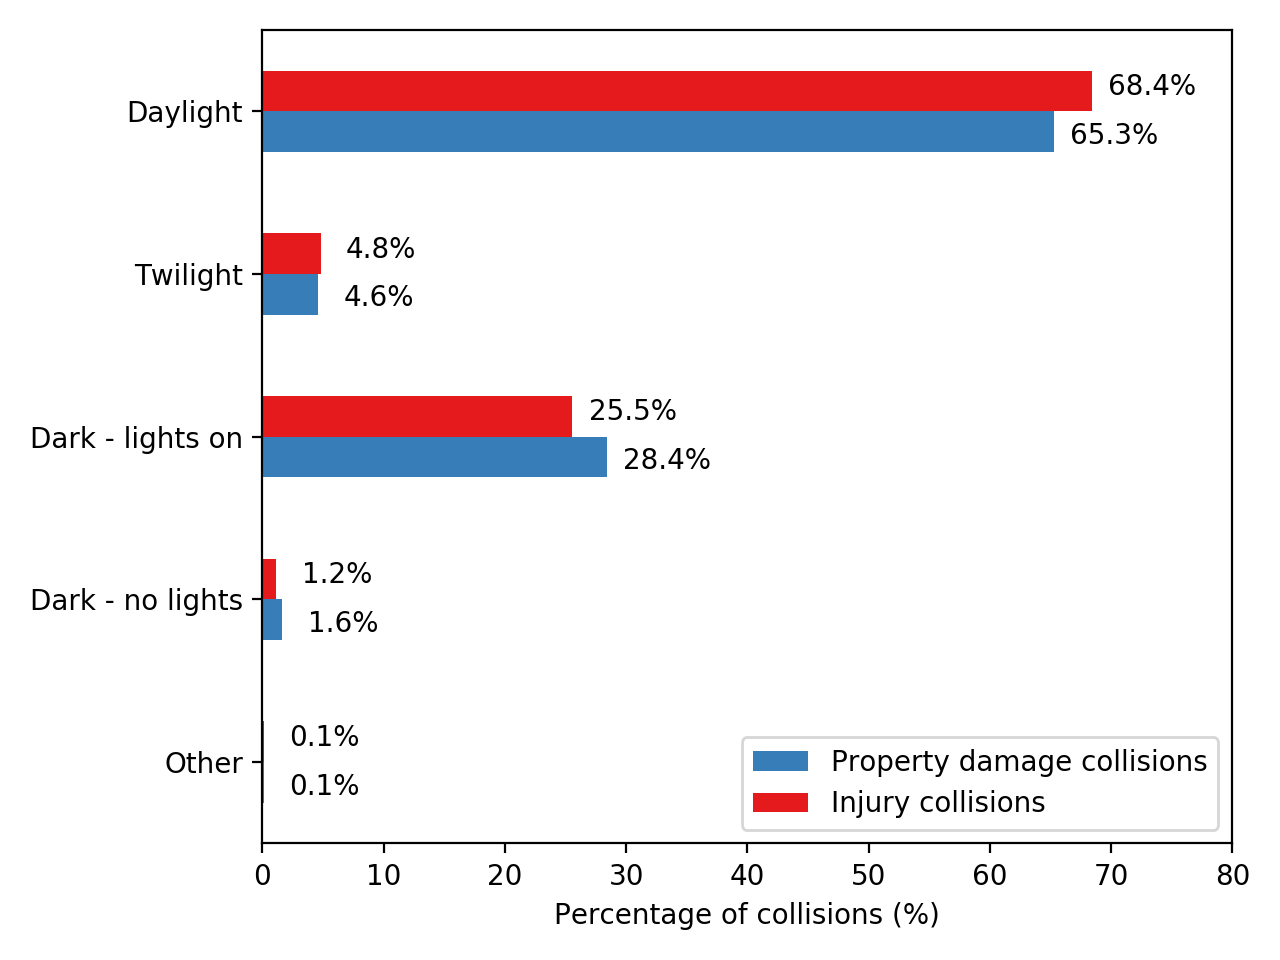

In [539]:
%matplotlib notebook

lights.plot(kind='barh',
            color=["#377eb8", "#e41a1c"])

for t in range(len(lights.index.values)):
    value1 = float(lights.iloc[t, 0])
    value2 = float(lights.iloc[t, 1])

    plt.annotate("{:.1f}%".format(value1), xy=(value1+5.0, t-0.15), ha='center', va='center')
    plt.annotate("{:.1f}%".format(value2), xy=(value2+5.0, t+0.15), ha='center', va='center')

plt.xlabel("Percentage of collisions (%)")
plt.ylabel("")
plt.xlim(0, 80)
plt.legend(labels=["Property damage collisions", "Injury collisions"], loc='lower right')
plt.tight_layout()
plt.savefig("Report/Collisions_vs_StreetLights.png", dpi=300)
plt.show()

The majority of the accidents happen at daylight. Next follow collisions during the night when the lights are on and at twilight. This is not surprising, given that the majority of the collisions actually happen late afternoon, early evening, when people come back from work. Interestingly, there are slightly more injury collisions during the day and twilight, as opposed to when it is dark.

In [540]:
# turn all categorical values to numerical
collisions['illumination'].replace(
    to_replace=["Daylight", "Twilight", "Dark - lights on", "Dark - no lights", "Other"], 
    value=[0, 1, 2, 3, 4], inplace=True
)

## Collision severity and junction types
Data concerning the type of junction where a collision happened is stored both under the feature address-type and junction-type. The former contains only three types, while the latter has much more detailed information on the precise location.

In [497]:
collisions[['severity', 'address-type', 'junction-type']].isnull().sum()

severity            0
address-type        2
junction-type    1390
dtype: int64

- the junction type has much more missing values and for this reason, the work will continue only with the address-type.

In [498]:
collisions = collisions.drop('junction-type', axis=1)

In [499]:
junction = collisions[['severity', 'address-type']].groupby(by=['severity', 'address-type']).size().unstack(level=1)
# normalize per row
junction.iloc[:,:] = Normalizer(norm='l1').fit_transform(junction)*100
junction

address-type,Alley,Block,Intersection
severity,,,
1,0.454508,68.798033,30.747459
2,0.127118,51.270136,48.602747


<IPython.core.display.Javascript object>


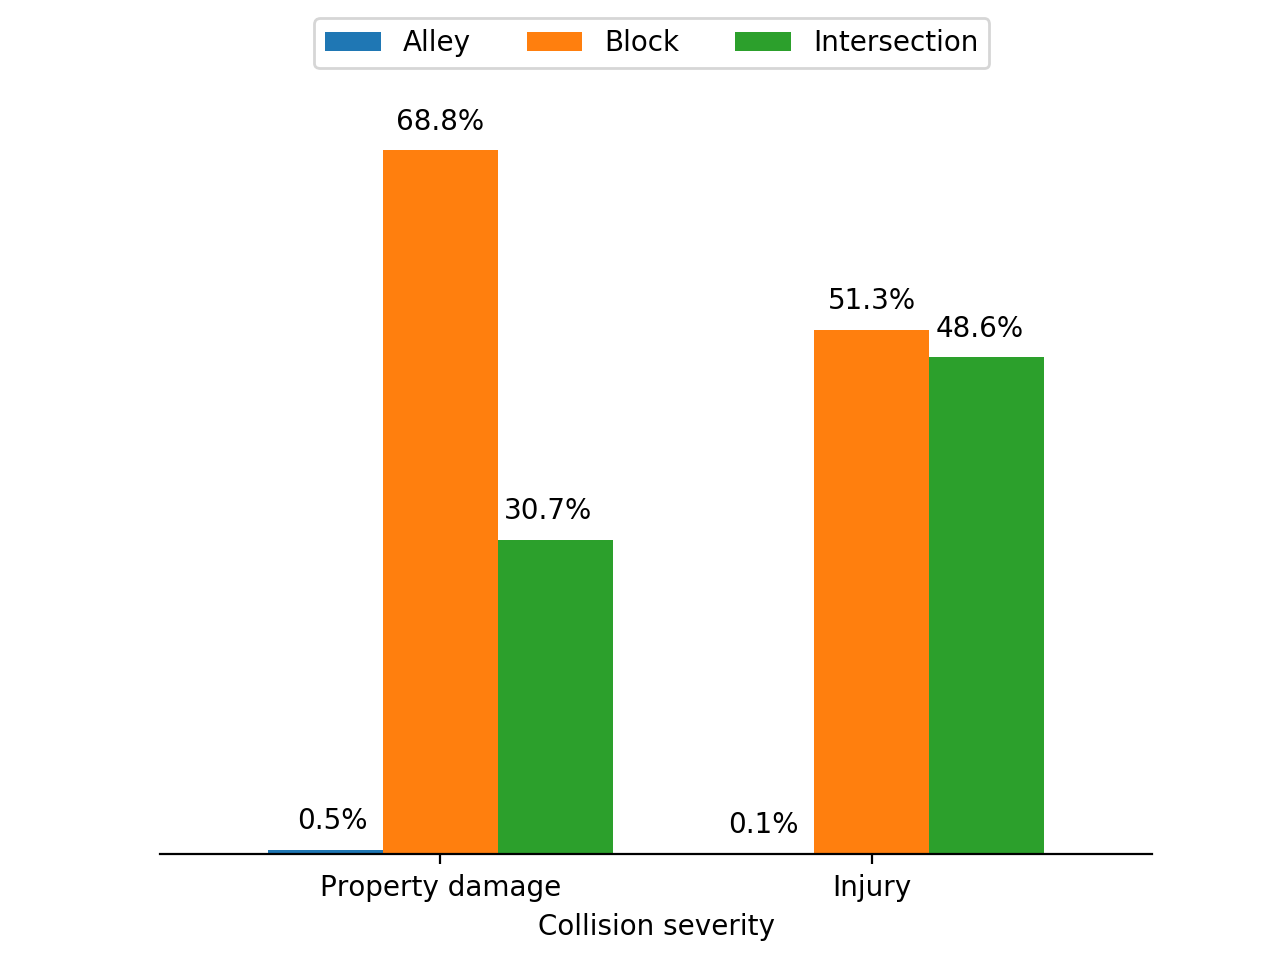

In [811]:
%matplotlib notebook

junction.plot(kind='bar',stacked=False, width=0.8)
plt.legend(ncol=3, bbox_to_anchor=(0.85, 1.15))

for t in range(1, 3, 1):
    value0 = float(junction.loc[t, 'Alley'])
    value1 = float(junction.loc[t, 'Block'])
    value2 = float(junction.loc[t, 'Intersection'])

    plt.annotate("{:.1f}%".format(value0), xy=(t-1.25, value0+2.0), ha='center')
    plt.annotate("{:.1f}%".format(value1), xy=(t-1.00, value1+2.0), ha='center')
    plt.annotate("{:.1f}%".format(value2), xy=(t-0.75, value2+2.0), ha='center')

plt.xticks([0, 1], ['Property damage', 'Injury'], rotation=0)
plt.xlabel("Collision severity")
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_yticklabels([])

plt.savefig("Report/Collisions_vs_Junctions.png", dpi=300)
plt.show()

Significant differences are observed between the two target classes. While almost two thirds of the collisions with property damage happen on a block, the collisions with injury are almost evenly split between block and intersection.

In [503]:
# turn all categorical values to numerical
collisions['address-type'].replace(
    to_replace=["Block", "Intersection", "Alley"], 
    value=[0, 1, 2], inplace=True
)

In [510]:
# change the name to the column for a more clear meaning
collisions.rename(columns={'address-type': 'road-segment'}, inplace=True)

In [730]:
collisions = collisions[collisions['road-segment'].notna()]

## Collision and number of participants
How does the number of pedestrians, cyclists and vehicles affect the severity of an accident?

### Number of people

In [552]:
people = collisions[['severity', 'persons', 'pedestrians', 'cyclists', 'vehicles']]
people.head()

,severity,persons,pedestrians,cyclists,vehicles
0,2,2,0,0,2
1,1,2,0,0,2
2,1,4,0,0,3
3,1,3,0,0,3
4,2,2,0,0,2


In [592]:
persons1.head()*100

,persons
0,3.511001
1,7.185208
2,58.418552
3,18.581758
4,7.121165


<IPython.core.display.Javascript object>


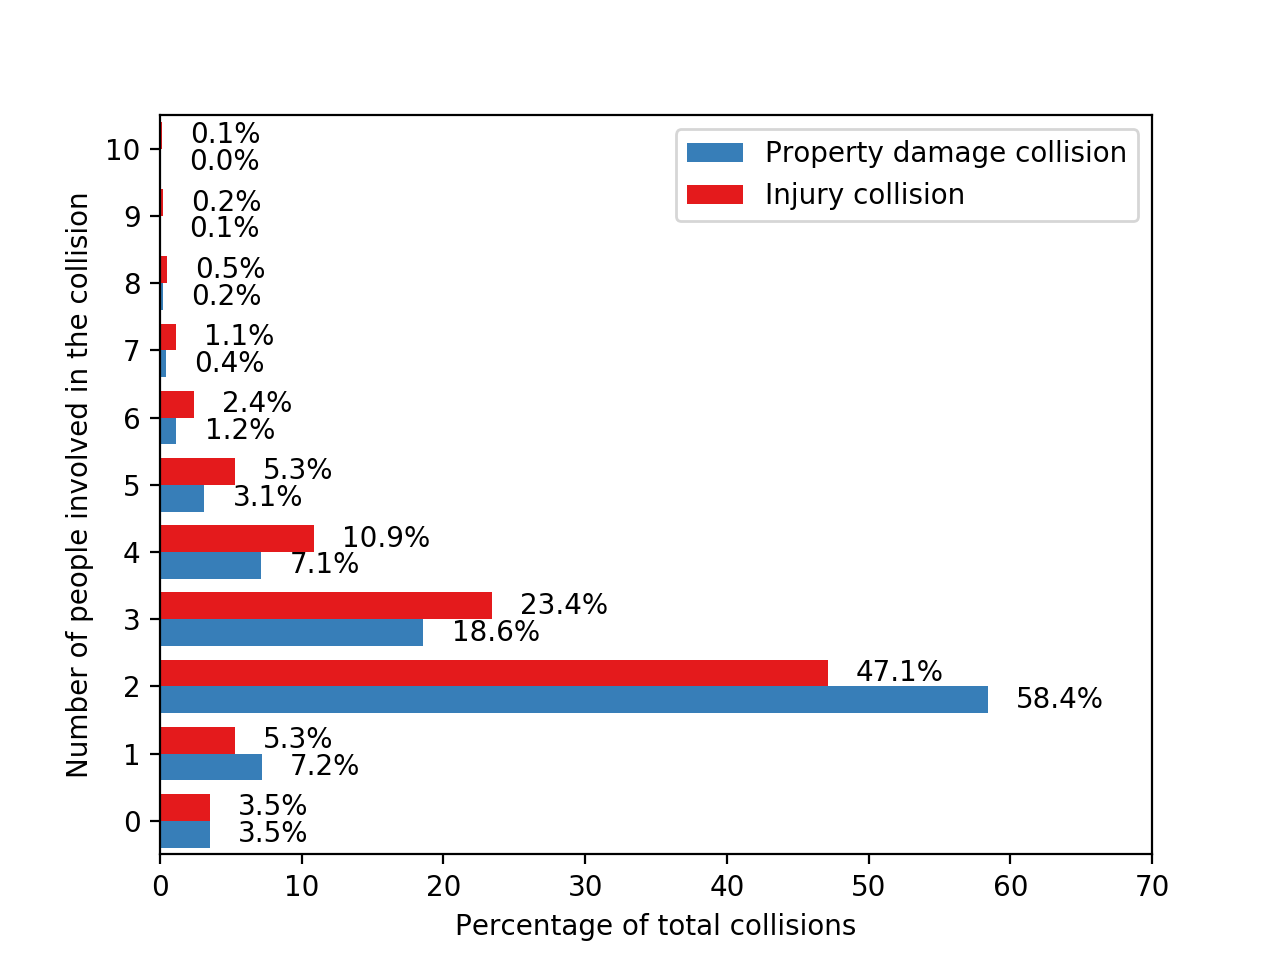

In [604]:
# prepare the data for plotting
persons1 = people[people['severity']==1]['persons'].value_counts(normalize=True).sort_index().to_frame()
persons2 = people[people['severity']==2]['persons'].value_counts(normalize=True).sort_index().to_frame()

%matplotlib notebook

fig = plt.figure()

plt.barh(persons1.index.values-0.2, persons1.persons.values*100,
         color="#377eb8", label="Property damage collision", height=0.4)
plt.barh(persons2.index.values+0.2, persons2.persons.values*100,
         color="#e41a1c", label="Injury collision", height=0.4)

for t in range(11):
    value1 = float(persons1.iloc[t, 0])*100
    value2 = float(persons2.iloc[t, 0])*100
    
    plt.annotate("{:.1f}%".format(value1), xy=(value1+2.0, t-0.2), va='center')
    plt.annotate("{:.1f}%".format(value2), xy=(value2+2.0, t+0.2), va='center')   

plt.ylim(-0.5, 10.5)
plt.xlim(0, 70)
plt.yticks(np.arange(11))
plt.ylabel("Number of people involved in the collision")
plt.xlabel("Percentage of total collisions")
plt.legend()
plt.savefig("Report/Severity_vs_Persons.png", dpi=300)
plt.show()

In [593]:
persons1.tail(1)

,persons
57,0.00001


In [594]:
persons2.tail(1)

,persons
81,0.000021


Most accidents happen with up to 10 people. The highest number of people involved in a collision with property damage is 57, whereas for injury - it is 81. 

### Number of pedestrians

In [603]:
# prepare the data for plotting
pedestrians1 = people[people['severity']==1]['pedestrians'].value_counts(normalize=True).sort_index().to_frame()
pedestrians2 = people[people['severity']==2]['pedestrians'].value_counts(normalize=True).sort_index().to_frame()

In [610]:
pedestrians2.index.values

array([0, 1, 2, 3, 4, 5, 6])

<IPython.core.display.Javascript object>


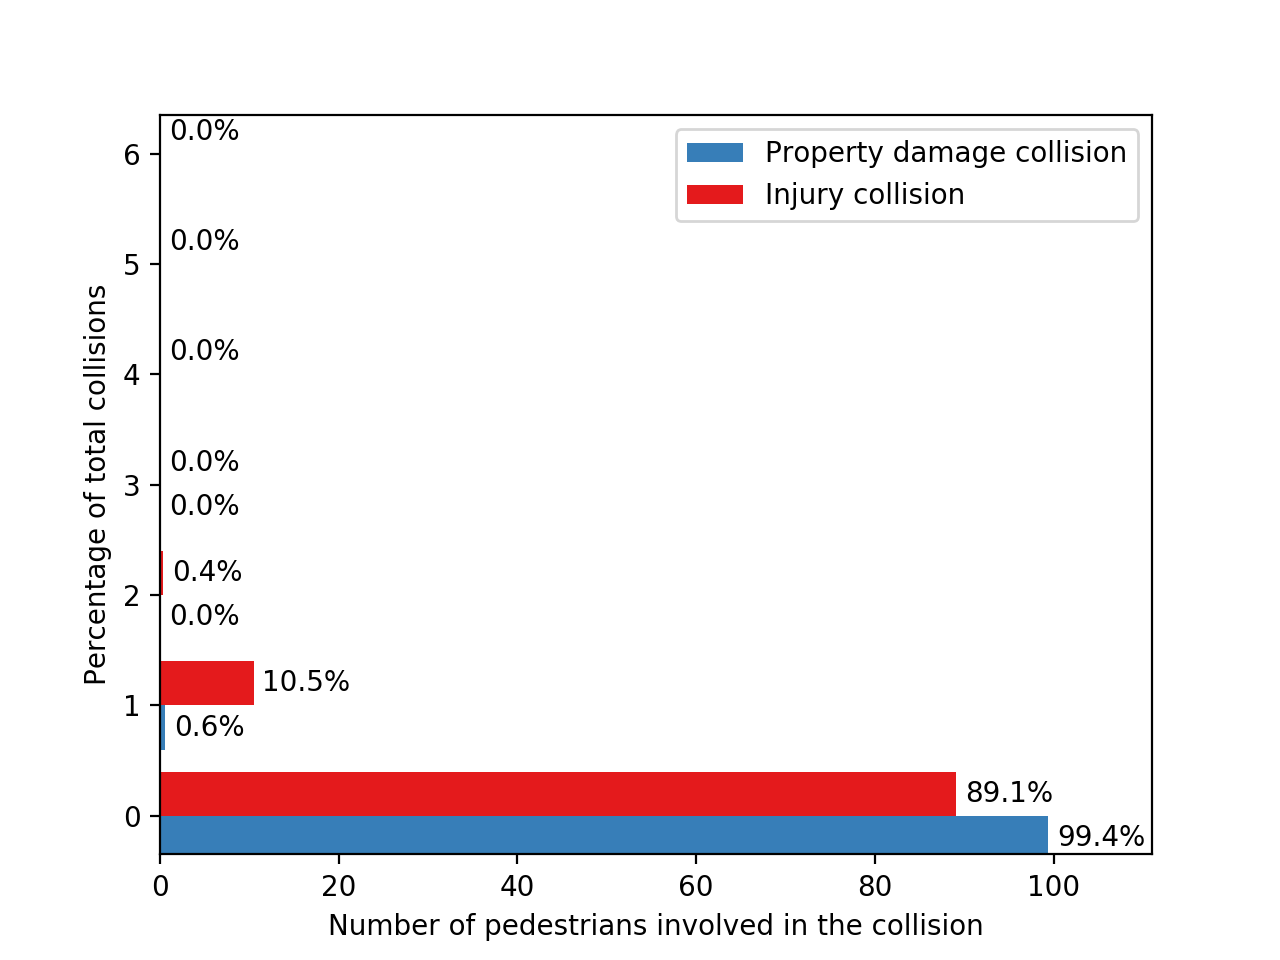

In [650]:
%matplotlib notebook

fig = plt.figure()

plt.barh(pedestrians1.index.values-0.2, pedestrians1.pedestrians.values*100,
                 color="#377eb8", label="Property damage collision", height=0.4)
plt.barh(pedestrians2.index.values+0.2, pedestrians2.pedestrians.values*100,
         color="#e41a1c", label="Injury collision", height=0.4)

for t in range(7):
    value2 = float(pedestrians2.iloc[t, 0])*100
    plt.annotate("{:.1f}%".format(value2), xy=(value2+1.0, t+0.2), va='center') 
    try:
        value1 = float(pedestrians1.iloc[t, 0])*100
        plt.annotate("{:.1f}%".format(value1), xy=(value1+1.0, t-0.2), va='center')        
    except IndexError:
        pass

plt.xlim(0, 111)
plt.ylim(-0.35, 6.35)
plt.xlabel("Number of pedestrians involved in the collision")
plt.ylabel("Percentage of total collisions")
plt.legend()
plt.savefig("Report/Severity_vs_pedestrians.png", dpi=300)
plt.show()

Maximum number of pedestrians involved in an accident of class 1 is 3, whereas for class 2 it is 6. The vast majority of damage collisions do not involve a pedestrian. 10.5% of the injury collisions involve a pedestrian. Given that most of the collisions involve either 1 or 0 pedestrians, the feature is turned into a classification of whether pedestrians are involved or not.

In [642]:
collisions['pedestrians'] = collisions['pedestrians'].apply(lambda x: 1 if x > 1 else x)

### Number of cyclists

In [643]:
# prepare the data for plotting
cyclists1 = people[people['severity']==1]['cyclists'].value_counts(normalize=True).sort_index().to_frame()
cyclists2 = people[people['severity']==2]['cyclists'].value_counts(normalize=True).sort_index().to_frame()

In [644]:
cyclists1

,cyclists
0,0.994381
1,0.005619


In [645]:
cyclists2

,cyclists
0,0.913873
1,0.085336
2,0.000792


<IPython.core.display.Javascript object>


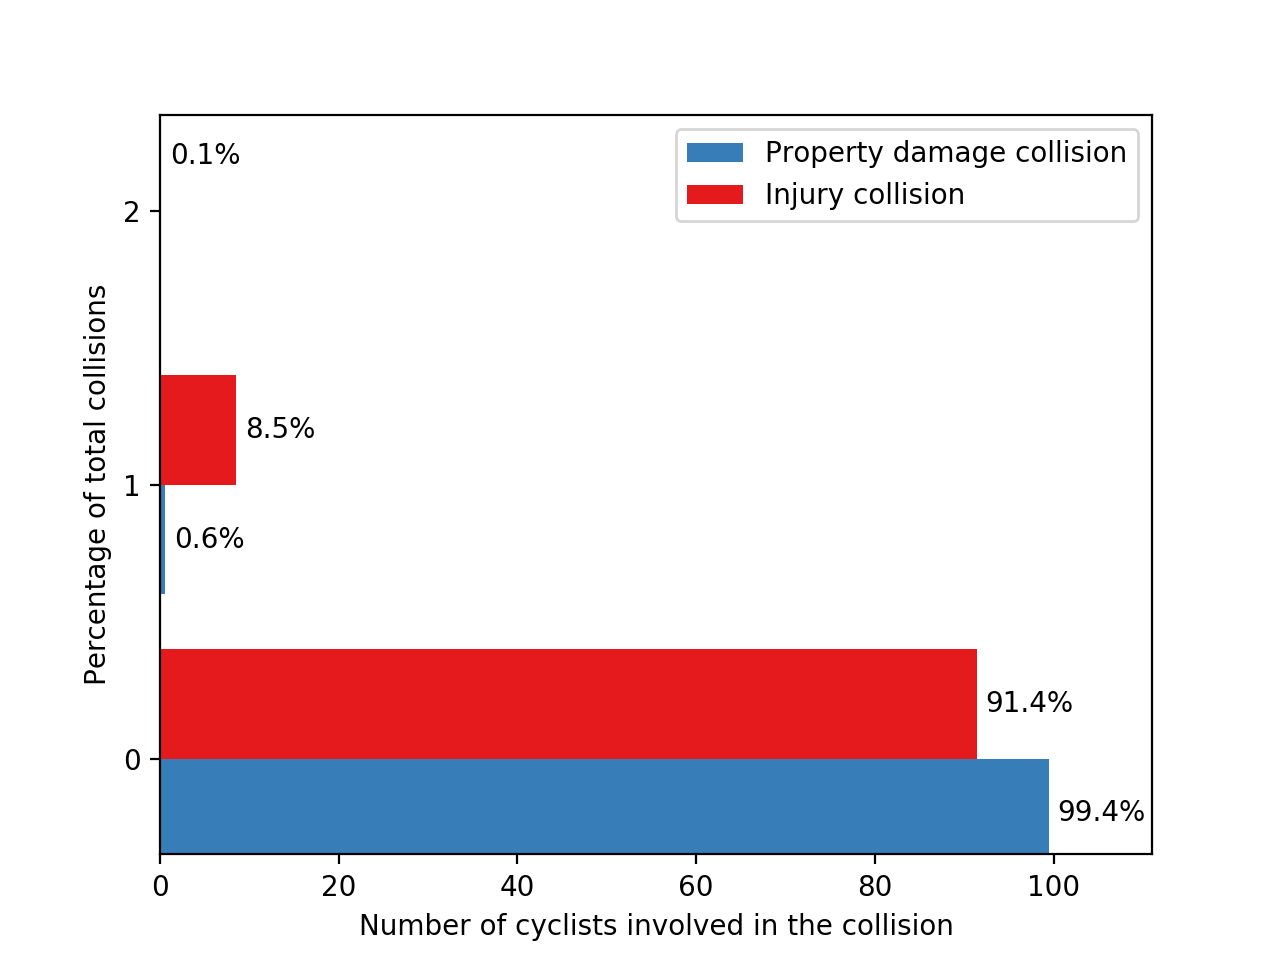

In [651]:
%matplotlib notebook

fig = plt.figure()

plt.barh(cyclists1.index.values-0.2, cyclists1.cyclists.values*100,
                 color="#377eb8", label="Property damage collision", height=0.4)
plt.barh(cyclists2.index.values+0.2, cyclists2.cyclists.values*100,
         color="#e41a1c", label="Injury collision", height=0.4)

for t in range(3):
    value2 = float(cyclists2.iloc[t, 0])*100
    plt.annotate("{:.1f}%".format(value2), xy=(value2+1.0, t+0.2), va='center') 
    try:
        value1 = float(cyclists1.iloc[t, 0])*100
        plt.annotate("{:.1f}%".format(value1), xy=(value1+1.0, t-0.2), va='center')        
    except IndexError:
        pass

plt.xlim(0, 111)
plt.ylim(-0.35, 2.35)
plt.yticks(np.arange(3))
plt.xlabel("Number of cyclists involved in the collision")
plt.ylabel("Percentage of total collisions")
plt.legend()
plt.savefig("Report/Severity_vs_cyclists.png", dpi=300)
plt.show()

The situation with the cyclists is similar to that with the pedestrians. The majority of recorded accidents happen with no cyclists. This feature is also turned into a binary one, indicating the participation of a cyclist or not.

In [652]:
collisions['cyclists'] = collisions['cyclists'].apply(lambda x: 1 if x > 1 else x)

### Number of vehicles

In [654]:
# prepare the data for plotting
vehicles1 = people[people['severity']==1]['vehicles'].value_counts(normalize=True).sort_index().to_frame()
vehicles2 = people[people['severity']==2]['vehicles'].value_counts(normalize=True).sort_index().to_frame()

In [655]:
vehicles1

,vehicles
0,0.000031
1,0.096581
2,0.824966
3,0.063578
4,0.011424
5,0.002355
6,0.000723
7,0.000196
8,0.000083
9,0.000021


In [656]:
vehicles2

,vehicles
0,0.003668
1,0.247463
2,0.627024
3,0.096943
4,0.018547
5,0.004647
6,0.001021
7,0.000396
8,0.000083
9,0.000125


<IPython.core.display.Javascript object>


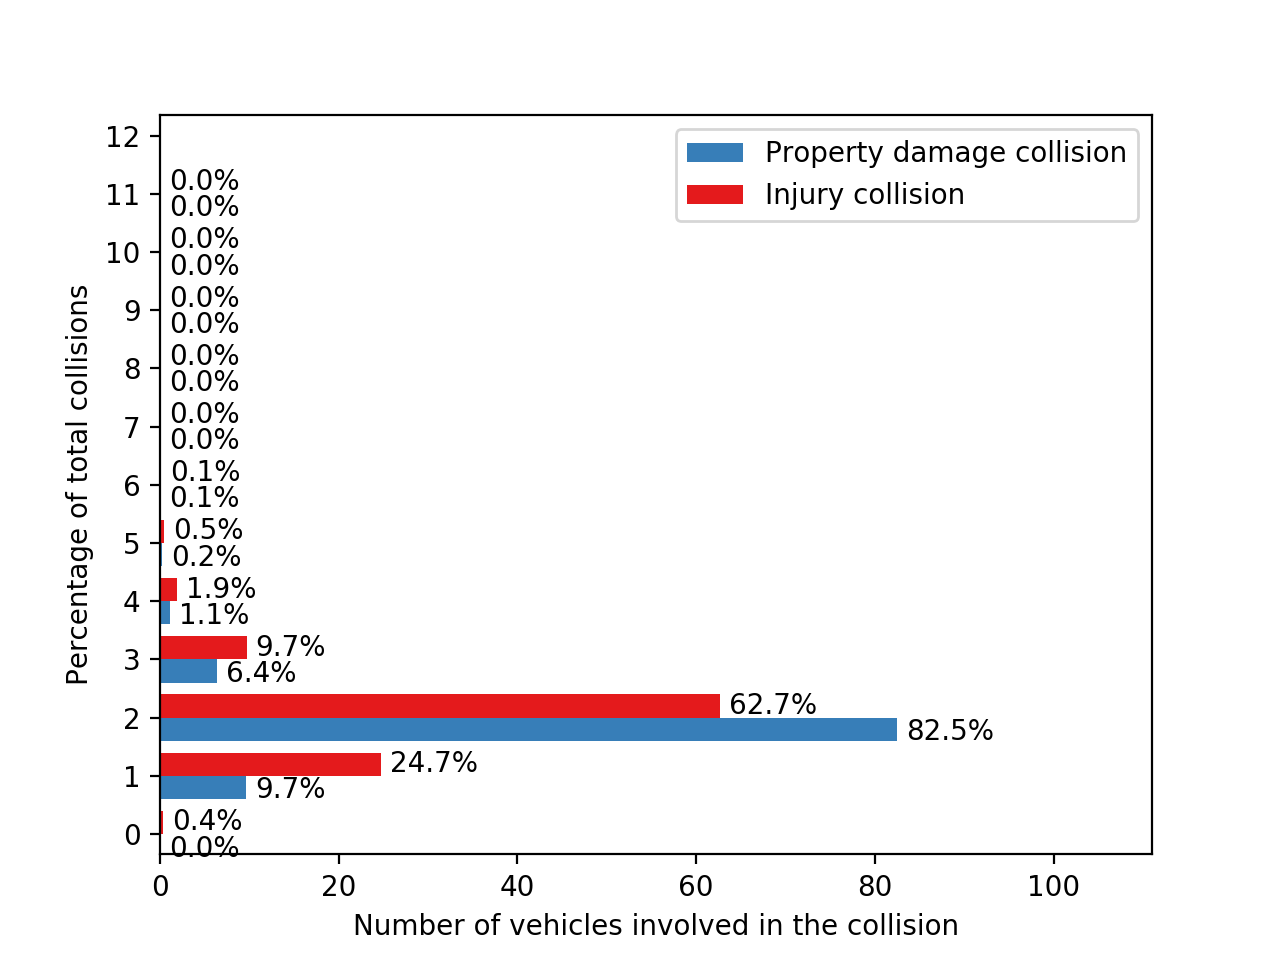

In [679]:
%matplotlib notebook

fig = plt.figure()

plt.barh(vehicles1.index.values-0.2, vehicles1.vehicles.values*100,
                 color="#377eb8", label="Property damage collision", height=0.4)
plt.barh(vehicles2.index.values+0.2, vehicles2.vehicles.values*100,
         color="#e41a1c", label="Injury collision", height=0.4)

for t in range(12):
    value1 = float(vehicles1.iloc[t, 0])*100
    plt.annotate("{:.1f}%".format(value1), xy=(value1+1.0, t-0.25), va='center') 
    try:
        value2 = float(vehicles2.iloc[t, 0])*100
        plt.annotate("{:.1f}%".format(value2), xy=(value2+1.0, t+0.2), va='center')        
    except IndexError:
        pass

plt.xlim(0, 111)
plt.ylim(-0.35, 12.35)
plt.yticks(np.arange(13))
plt.xlabel("Number of vehicles involved in the collision")
plt.ylabel("Percentage of total collisions")
plt.legend()
plt.savefig("Report/Severity_vs_vehicles.png", dpi=300)
plt.show()

Having a high number of vehicles in a collision is rare. Most of the accidents happen with two vehicles. Such crashes are mostly with property damages and to a lesser extent with injuries. When only one vehicle is involved, it is to be expected that most accidents will be with injuries. This can be ascribed to accidents involving collisions with pedestrians or cyclists.

Overall, there is a strong dependence of the number of participants in a collision, on the severity class.

## Collision severity and Codes 
The codes gives information about the types of collision that is reported. While the code describe how the crash happened, it may give insight into what types of accidents are to be avoided.

Let's have a look at what column names have remained.

In [682]:
collisions.columns.values

array(['severity', 'longitude', 'latitude', 'road-segment',
       'collision-type', 'persons', 'pedestrians', 'cyclists', 'vehicles',
       'year', 'day-of-week', 'hour', 'time-of-day', 'SDOT-code',
       'SDOT-description', 'inattention', 'under-influence', 'weather',
       'road-condition', 'illumination', 'pedestrian-row', 'SDOTCOLNUM',
       'speeding', 'state-code', 'state-description', 'hit-parked-car',
       'cold-months'], dtype=object)

In terms of type of collision, there are 6 features: "collision-type", the SDOT code and description, the state code and description. Finally, there is the column "SDOTCOLNUM", which contains a number to the collision. Which columns can be useful?

In [695]:
collisions['collision-type'].unique()

array(['Angles', 'Sideswipe', 'Parked Car', 'Other', 'Rear Ended',
       'Head On', 'Cycles', 'Left Turn', 'Pedestrian', 'Right Turn', nan],
      dtype=object)

In [696]:
collisions['SDOT-code'].unique()

array([11, 16, 14, 13, 18, 34, 28, 24, 69,  0, 23, 12, 26, 51, 29, 48, 15,
       33, 54, 31, 44, 32, 27, 21, 25, 66, 56, 64, 55, 58, 36, 47, 61, 22,
       53, 46, 35, 52, 68])

In [708]:
collisions['SDOT-description'].unique()

array(['MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE',
       'MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE',
       'MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END',
       'MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE',
       'MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE',
       'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END',
       'MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT',
       'MOTOR VEHCILE STRUCK PEDESTRIAN',
       'PEDALCYCLIST OVERTURNED IN ROAD',
       'NOT ENOUGH INFORMATION / NOT APPLICABLE',
       'MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE SIDESWIPE',
       'MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE',
       'MOTOR VEHICLE STRUCK OBJECT IN ROAD',
       'PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE',
       'MOTOR VEHICLE OVERTURNED IN ROAD',
       'DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT',
       'MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE',
       'DRIVERLESS VEHICL

In [698]:
collisions['state-code'].unique()

array(['10', '11', '32', '23', '22', '14', '30', '5', '28', '13', '50',
       '12', '0', '20', '45', '21', '1', '52', '16', '15', '74', '81',
       '51', '26', '19', '2', '66', '3', '40', '71', '83', '25', '6',
       '24', '27', '4', '57', '72', '29', '56', '73', '41', '17', '82',
       '67', '49', '84', '31', '42', '48', '64', '53', '65', 32, 50, 15,
       10, 14, 13, 22, 51, 11, 28, 12, 52, 21, 19, 20, 16, 27, 83, 45, 65,
       30, 0, 71, 1, 23, 2, 29, 81, 25, 24, 26, 4, 74, 72, 3, 73, 57, 42,
       84, 41, 64, 66, 56, 40, 82, 67, '54', 53, 48, 43, 87, 31, 54, '87',
       nan, '7', '8', ' ', '85', '88', '18'], dtype=object)

In [710]:
collisions['state-description'].unique()

array(['Entering at angle',
       'From same direction - both going straight - both moving - sideswipe',
       'One parked--one moving', 'From same direction - all others',
       'One car leaving driveway access',
       'From same direction - both going straight - one stopped - rear-end',
       'From opposite direction - all others',
       'Vehicle Strikes Pedalcyclist',
       'From opposite direction - one left turn - one straight',
       'From same direction - both going straight - both moving - rear-end',
       'Fixed object',
       'From same direction - both going straight - one stopped - sideswipe',
       'Vehicle going straight hits pedestrian',
       'One car leaving parked position', 'Vehicle - Pedalcyclist',
       'One car entering driveway access',
       'Vehicle turning right hits pedestrian', 'Vehicle overturned',
       'From same direction - one right turn - one straight',
       'From same direction - one left turn - one straight',
       'Same direction -

In [700]:
collisions['SDOTCOLNUM'].unique()

array([      nan,  6354039.,  4323031., ..., 13019005., 13034014.,
       13060031.])

In [692]:
collisions[['collision-type', 'SDOT-code', 'SDOT-description', 'state-code', 'state-description', 'SDOTCOLNUM']].head()

,collision-type,SDOT-code,SDOT-description,state-code,state-description,SDOTCOLNUM
0,Angles,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",10,Entering at angle,NaN
1,Sideswipe,16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",11,From same direction - both going straight - bo...,6354039.0
2,Parked Car,14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",32,One parked--one moving,4323031.0
3,Other,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",23,From same direction - all others,NaN
4,Angles,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",10,Entering at angle,4028032.0


In [694]:
collisions[['collision-type', 'SDOT-code', 'SDOT-description', 'state-code', 'state-description', 'SDOTCOLNUM']].isnull().sum()

collision-type          17
SDOT-code                0
SDOT-description         0
state-code              16
state-description       17
SDOTCOLNUM           65247
dtype: int64

The information of interest for this project is a classification of the accident types and if any specific type would lead to more serious accidents or not. This is already provided by the "collision-type" column, which has 10 categories. The SDOT-code and state-code provide a much more detailed information on the exact type of collision offering one category out of 36 (SDOT) or 62 (state) values. So many categories may prove more difficult to interpret and more wider categories may be more useful. For this purpose, I will keep only the "collision-type" column and work with that. The SDOTCOLNUM does not provide any useful information, so it is dropped as well.

In [717]:
collisions = collisions.drop(columns=['SDOT-code', 'SDOT-description', 
                                      'state-code', 'state-description', 'SDOTCOLNUM'], axis=1)

The column "hit-parked-car" contains information about where a parked car was hit. This information is already provided by the "collision-type" feature, so the column was also dropped.

In [722]:
collisions = collisions.drop(columns=['hit-parked-car',], axis=1)

In [724]:
collisions.columns.values

array(['severity', 'longitude', 'latitude', 'road-segment',
       'collision-type', 'persons', 'pedestrians', 'cyclists', 'vehicles',
       'year', 'day-of-week', 'hour', 'time-of-day', 'inattention',
       'under-influence', 'weather', 'road-condition', 'illumination',
       'pedestrian-row', 'speeding', 'cold-months'], dtype=object)

In [731]:
# delete any NaN values
collisions = collisions[collisions['collision-type'].notna()]

In [738]:
codes = collisions[['severity', 'collision-type']].groupby(by=['severity', 'collision-type']).size().unstack(level=1)
# normalize per row
codes.iloc[:,:] = Normalizer(norm='l1').fit_transform(codes)*100
codes

collision-type,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
severity,,,,,,,,,,
1,18.255633,0.553702,1.005134,7.171265,14.173114,26.560127,0.567131,16.279454,1.976178,13.458261
2,24.377280,8.498176,1.563314,9.671704,10.305367,4.616988,10.322043,25.186034,1.056800,4.402293


In [763]:
codes = codes[['Head On', 'Rear Ended', 'Angles', 'Sideswipe', 
               'Left Turn', 'Right Turn', 
               'Cycles', 'Pedestrian',
               'Parked Car','Other']]

<IPython.core.display.Javascript object>


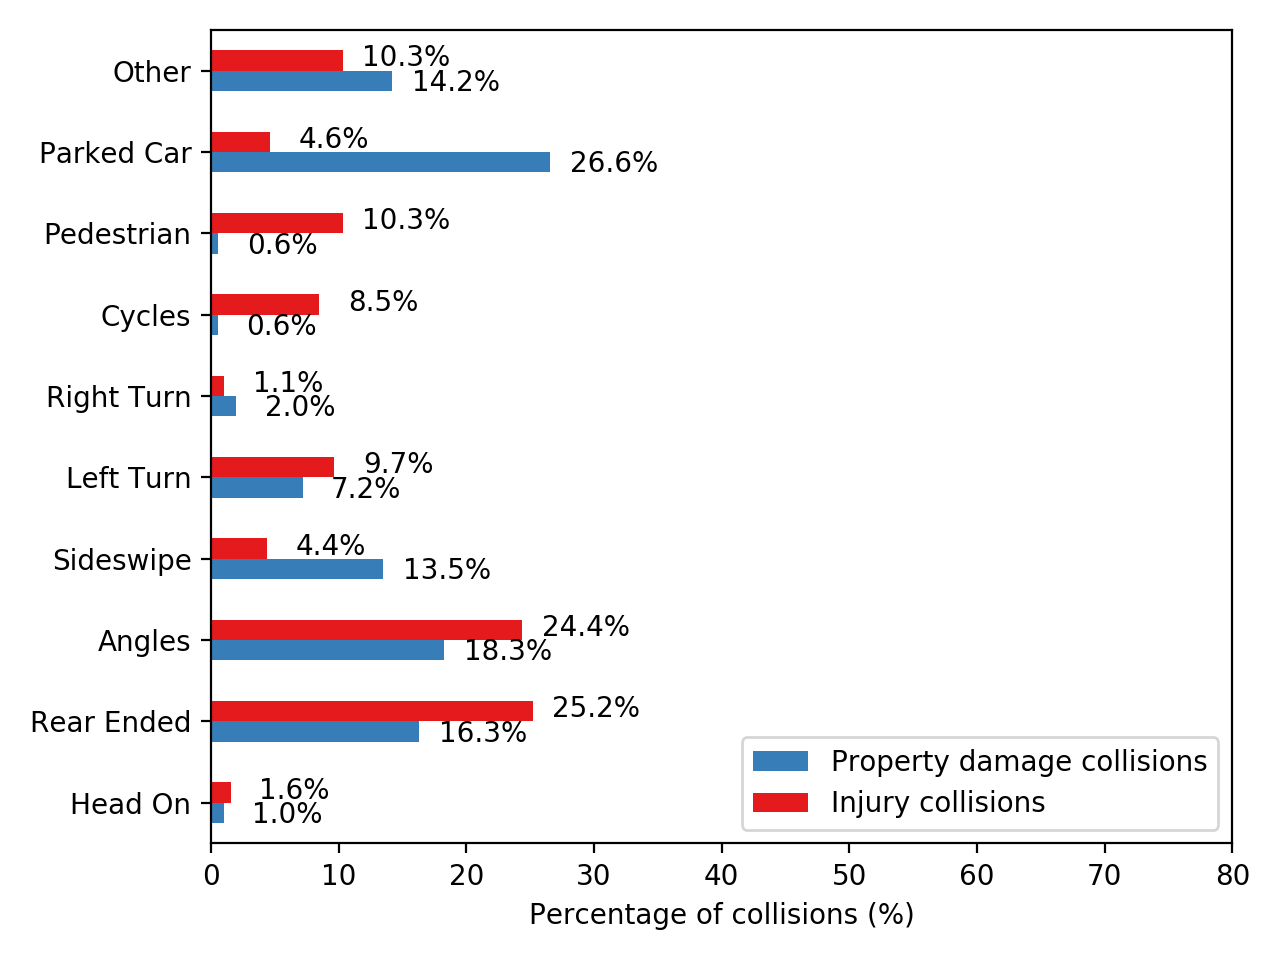

In [764]:
%matplotlib notebook

codes.T.plot(kind='barh',
            color=["#377eb8", "#e41a1c"])

for t in range(len(codes.T.index.values)):
    value1 = float(codes.T.iloc[t, 0])
    value2 = float(codes.T.iloc[t, 1])

    plt.annotate("{:.1f}%".format(value1), xy=(value1+5.0, t-0.15), ha='center', va='center')
    plt.annotate("{:.1f}%".format(value2), xy=(value2+5.0, t+0.15), ha='center', va='center')

plt.xlabel("Percentage of collisions (%)")
plt.ylabel("")
plt.xlim(0, 80)
plt.legend(labels=["Property damage collisions", "Injury collisions"], loc='lower right')
plt.tight_layout()
plt.savefig("Report/Collisions_vs_Codes.png", dpi=300)
plt.show()

The type of collision offers insights on how severe the accident is. Crashes with pedestrians or cyclists are much more likely to involve injuries. In addition, about one-fourth of all injury collisions happen during rear-ended, with often spinal injuries, and one-fourth during accidents at angles. By comparison, the most prevalent collision type with property damage is actually going against a parked car. This is followed by angles, rear-ended and sideswipe collisions. Head-On or right-turn accidents appear to be rare overall, whereas turning left more often leads to crashes.

In [848]:
# turn all categorical values to numerical
collisions['collision-type'].replace(
    to_replace=['Head On', 'Rear Ended', 'Angles', 'Sideswipe', 
               'Left Turn', 'Right Turn', 
               'Cycles', 'Pedestrian',
               'Parked Car','Other'], 
    value=np.arange(10), inplace=True
)

In [818]:
right_way = collisions[collisions['collision-type']=='Pedestrian'][['severity', 'pedestrian-row']].groupby(by=['severity', 
                                                                 'pedestrian-row']).size().unstack(level=1)
# normalize per row
right_way.iloc[:,:] = Normalizer(norm='l1').fit_transform(right_way)*100
right_way

pedestrian-row,0,1
severity,,
1,63.570128,36.429872
2,55.896607,44.103393


<IPython.core.display.Javascript object>


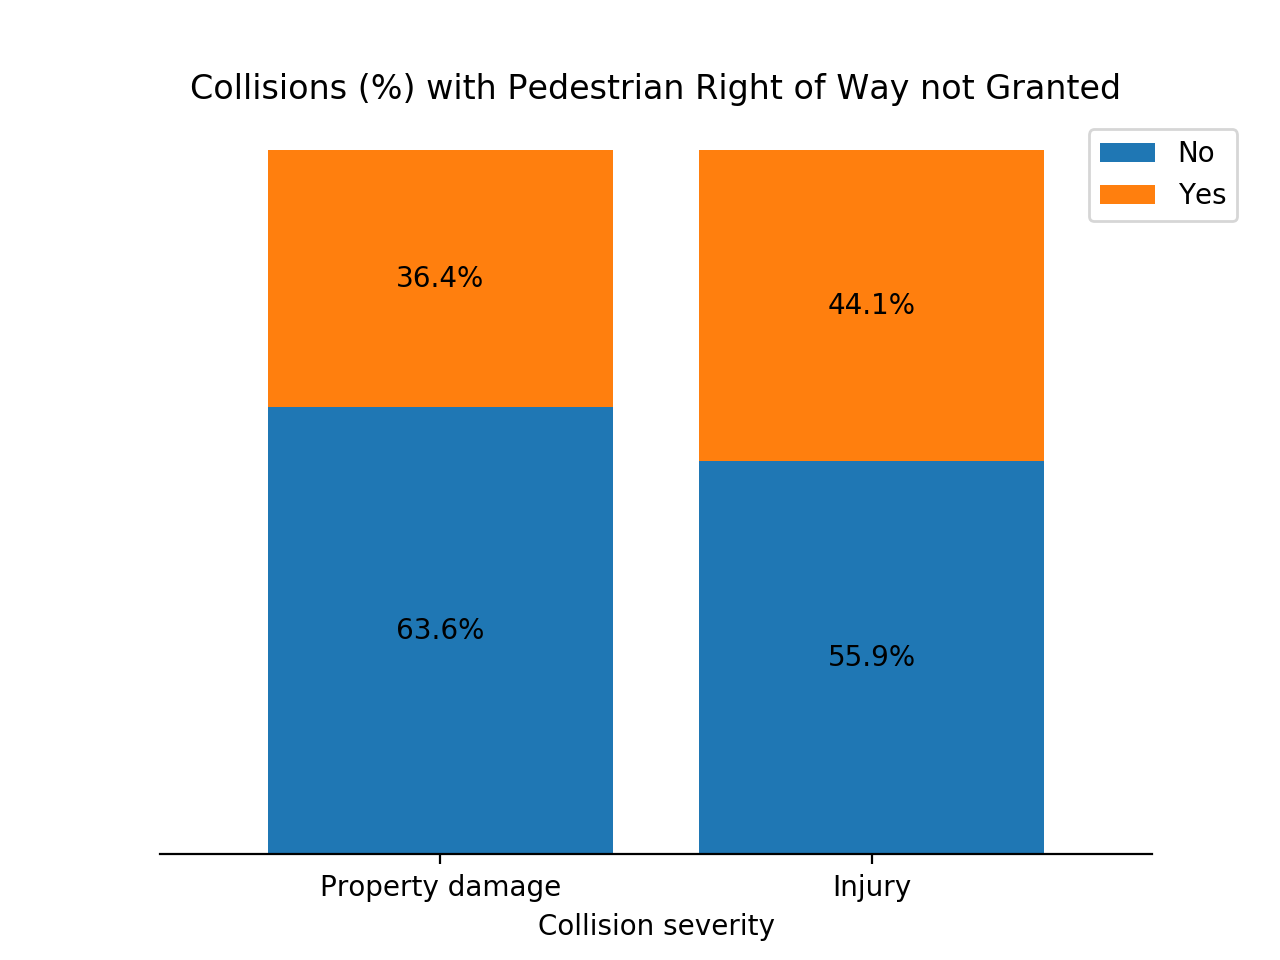

In [820]:
%matplotlib notebook

right_way.plot(kind='bar',stacked=True, width=0.8)
plt.legend(labels= ['No', 'Yes'], bbox_to_anchor=(1.1, 1.0))

value10 = right_way.iloc[0, 0]
value11 = right_way.iloc[0, 1]
value20 = right_way.iloc[1, 0]
value21 = right_way.iloc[1, 1]

plt.annotate("{:.1f}%".format(value10), xy=(0, (value10)*0.5), va='center', ha='center')
plt.annotate("{:.1f}%".format(value11), xy=(0, (value11)*0.5+value10), ha='center', va='center')
plt.annotate("{:.1f}%".format(value20), xy=(1, (value20)*0.5), ha='center', va='center')
plt.annotate("{:.1f}%".format(value21), xy=(1, (value21)*0.5+value20), ha='center', va='center')

plt.xticks([0, 1], ['Property damage', 'Injury'], rotation=0)
plt.xlabel("Collision severity")
plt.title("Collisions (%) with Pedestrian Right of Way not Granted")    
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_yticklabels([])

plt.savefig("Report/Collisions_vs_RightWay.png", dpi=300)
plt.show()

From the previous graph we already know that only 10.3% (injury collisions) and 0.6% (property collisions) of all accidents involve pedestrians. In proportion, it appears that less than a half of these, that result in injury, happen because the pedestrian right of way was not granted, the number being one third for the property damage collision.

## Collision severity and other factors
How do other factors, such as the inattention of the driver, their driving under the influence of drugs/alcohol or reckless driving with high speed, contribute to the severity of an accident?

In [827]:
# extract the necessary data
factors = collisions[['severity', 'speeding', 'inattention', 'under-influence']]
factors = factors.groupby(by='severity').sum()

# transform into percentage with respect to each collision severity level.
for s in factors.index.values:
    for c in factors.columns.values:
        if s == 1:
            factors.loc[s, c] = round(factors.loc[s, c] / sev1 * 100, 2)      
        elif s == 2:
            factors.loc[s, c] = round(factors.loc[s, c] / sev2 * 100, 2) 

factors.insert(3, 'other', 100.0-factors['speeding']-factors['inattention']-factors['under-influence'])
factors

,speeding,inattention,under-influence,other
severity,,,,
1,3.53,3.53,3.60,89.34
2,5.08,5.08,5.25,84.59


<IPython.core.display.Javascript object>


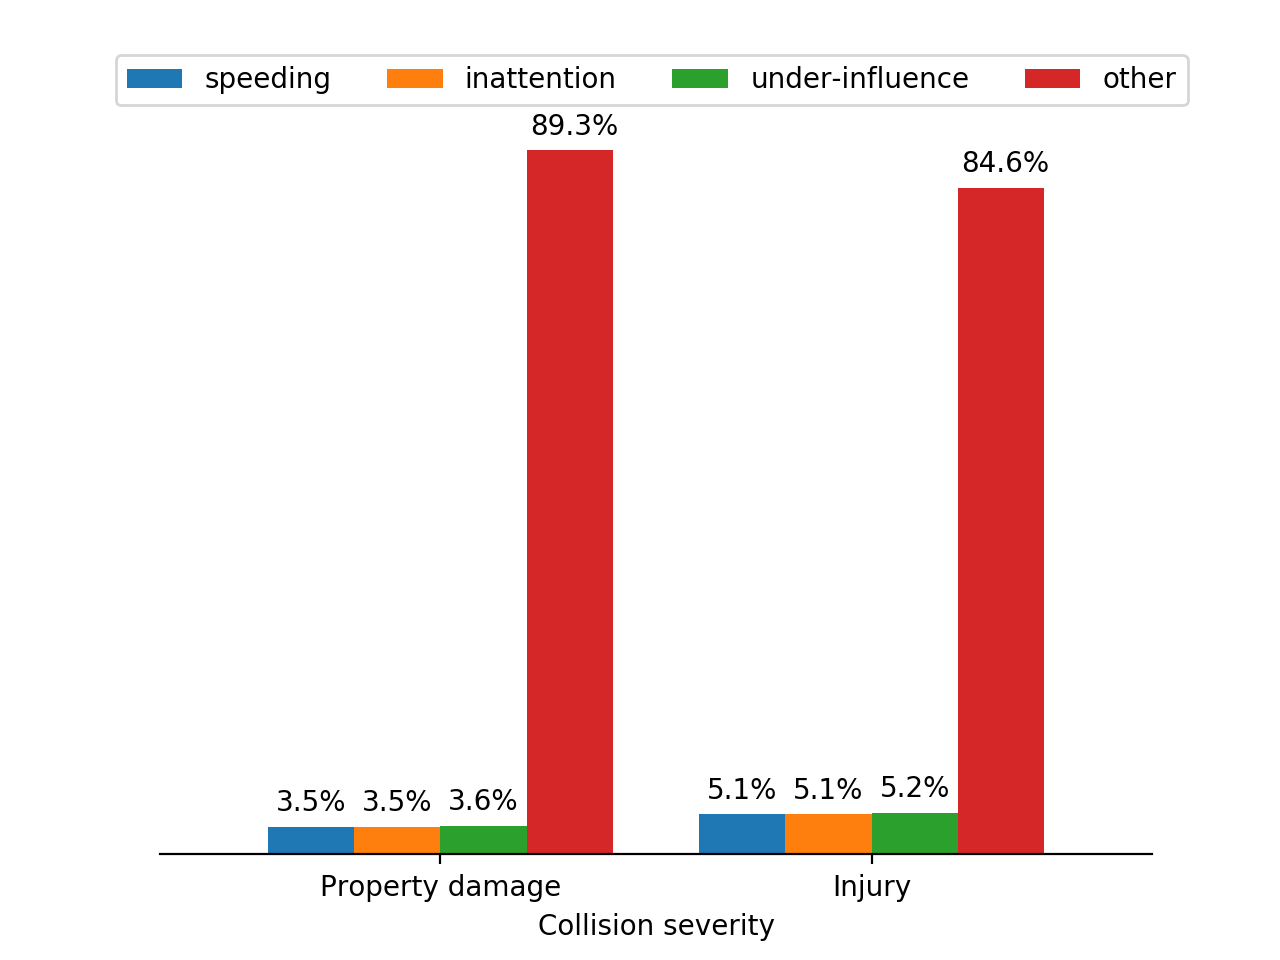

In [1154]:
%matplotlib notebook

#plt.rcParams.update({'font.size':10})
factors.plot(kind='bar',stacked=False, width=0.8)
plt.legend(ncol=4, bbox_to_anchor=(1.05, 1.1))

for t in range(1, 3, 1):
    value0 = float(factors.loc[t, 'speeding'])
    value1 = float(factors.loc[t, 'inattention'])
    value2 = float(factors.loc[t, 'under-influence'])
    value3 = float(factors.loc[t, 'other'])

    plt.annotate("{:.1f}%".format(value0), xy=(t-1.30, value0+2.0), ha='center')
    plt.annotate("{:.1f}%".format(value1), xy=(t-1.10, value1+2.0), ha='center')
    plt.annotate("{:.1f}%".format(value2), xy=(t-0.90, value2+2.0), ha='center')
    plt.annotate("{:.1f}%".format(value3), xy=(t-0.69, value3+2.0), ha='center')
plt.xticks([0, 1], ['Property damage', 'Injury'], rotation=0)
plt.xlabel("Collision severity")
    
ax = plt.gca()
#ax.set_aspect(aspect=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_yticklabels([])

plt.savefig("Report/Collisions_vs_factors.png", dpi=300)
plt.show()

Interestingly, more accidents with injuries happen in proportion as result of such reckless driving. The overall numbers, however, remain almost the same for speeding, inattention or driving under the influence of drugs or alcohol.

## Collision Location
Do more injury collisions happen at a specific location?

In [861]:
# delete any NaN values
collisions = collisions[collisions['longitude'].notna()]
collisions[['longitude', 'latitude']].isnull().sum()

longitude    0
latitude     0
dtype: int64

In [888]:
accidents_map = folium.Map(
    location=[47.609722, -122.333056],
    zoom_start=11,
    tiles='Stamen Terrain',
    subdomains='abcd'
)

colors = ["#377eb8", "#e41a1c"]
colors_r = ["white", "black"]

p_maps = collisions[(collisions['collision-type']==7) & (collisions['year']==2019)] # pedestrian
# pedestrians
for lat, lng, s, r in zip(p_maps.latitude, p_maps.longitude, p_maps.severity, p_maps['pedestrian-row']):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color=colors[s-1],
        fill=True,
        fill_color=colors_r[r],
        fill_opacity=1.0
    ).add_to(accidents_map)
    
accidents_map.save("folium_pedestrians.html")   
accidents_map

In [897]:
accidents_map = folium.Map(
    location=[47.609722, -122.333056],
    zoom_start=11,
    tiles='Stamen Terrain',
    subdomains='abcd'
)

colors = ["#377eb8", "#e41a1c"]

c_maps = collisions[(collisions['collision-type']==6) & (collisions['year']==2019)] # cycles
for lat, lng ,s in zip(c_maps.latitude, c_maps.longitude, c_maps.severity):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color=colors[s-1],
        fill=False,
        fill_color='white',
        fill_opacity=1.0
    ).add_to(accidents_map)
    
accidents_map.save("folium_cyclists.html")    
accidents_map

Let's look where collisions with pedestrians and cyclists during the last year take place. The majority seem to happen in central Seattle. The pedestrian right of way is rather homogenously not granted.

# Machine Learning 
This project aims at determining the factors leading to a collision being only property damage or wiht injuries. The problem is thus is a classification one. Therefore, several classification algorithms will be tested for accuracy and precision.

The dataset that is used here is imbalanced - there are many more cases with severity 1 and severity two. There are several ways to deal with this problem. Either random sampling of the majority class, so as to obtain a balanced data set, or a cost-based approach, where additional weight is added to instances of the minority class.

In this project three methods will be tested - the Decision Tree, the Balanced Random Forest and the XGBoost, the last two of which account for the data imbalance.

## Data preparation

In [1016]:
collisions.corr()*100

,severity,longitude,latitude,road-segment,collision-type,persons,pedestrians,cyclists,vehicles,year,day-of-week,hour,inattention,under-influence,weather,road-condition,illumination,pedestrian-row,speeding,cold-months
severity,100.000000,0.893280,2.602358,17.532403,-14.526954,10.763418,24.769912,21.492047,-8.541530,2.657795,-1.926524,-2.462709,2.834898,3.007407,-0.807752,-0.434745,-3.491619,20.203835,2.834898,2.032892
longitude,0.893280,100.000000,-15.713772,0.085639,-2.961892,1.081284,1.099261,-0.406025,-1.300868,0.837423,-1.020441,-1.663765,-1.064307,-3.566908,0.176660,0.922332,-2.270555,0.697204,-1.064307,-0.055991
latitude,2.602358,-15.713772,100.000000,4.470964,-3.152943,-0.938904,1.501591,3.004665,1.864510,-2.045075,-0.536347,1.132865,-2.640740,-0.546056,0.097368,-1.080009,-0.840691,2.632136,-2.640740,0.534012
road-segment,17.532403,0.085639,4.470964,100.000000,-24.257186,4.585964,14.245608,7.829465,-9.748478,3.827957,-0.798652,-3.528147,-6.760354,-5.693255,0.128623,0.397286,-3.146867,15.123957,-6.760354,-1.937989
collision-type,-14.526954,-2.961892,-3.152943,-24.257186,100.000000,-21.513208,16.588579,9.118070,-30.012274,-5.597198,3.580974,12.297922,7.039018,11.054593,-0.063698,0.017571,15.365502,11.654560,7.039018,-0.535956
persons,10.763418,1.081284,-0.938904,4.585964,-21.513208,100.000000,-3.991869,-4.867822,39.073331,-6.049904,6.240699,2.271562,-0.589339,1.397417,-0.674836,-0.320938,-0.831433,-3.358559,-0.589339,-0.585309
pedestrians,24.769912,1.099261,1.501591,14.245608,16.588579,-3.991869,100.000000,-2.082318,-33.102549,2.735150,-2.110206,-0.987310,-3.775465,1.197867,0.842173,1.422450,2.442148,49.958784,-3.775465,-3.615975
cyclists,21.492047,-0.406025,3.004665,7.829465,9.118070,-4.867822,-2.082318,100.000000,-31.538285,3.688738,-2.915063,-3.504407,-2.337161,-2.098103,-2.995319,-4.504423,-4.071968,32.090058,-2.337161,4.359419
vehicles,-8.541530,-1.300868,1.864510,-9.748478,-30.012274,39.073331,-33.102549,-31.538285,100.000000,-1.103257,0.633213,-1.522841,-3.960012,-0.927129,-1.004478,-2.249397,-3.651538,-27.936892,-3.960012,0.667201
year,2.657795,0.837423,-2.045075,3.827957,-5.597198,-6.049904,2.735150,3.688738,-1.103257,100.000000,-1.688754,-3.727523,-4.073014,0.250536,-2.024296,-1.170622,-1.170490,-1.746138,-4.073014,-0.755411


In [937]:
features = collisions[:]
features = features.drop(columns=['severity', 'time-of-day'], axis=1)
features.head(1)

,longitude,latitude,road-segment,collision-type,persons,pedestrians,cyclists,vehicles,year,day-of-week,hour,inattention,under-influence,weather,road-condition,illumination,pedestrian-row,speeding,cold-months
0,-122.323148,47.70314,1.0,2,2,0,0,2,2013,0,2,0,0,2,1,0,0,0,0


In [993]:
# extract the values of the features
X = features.values

# extract the values of target
Y = collisions[['severity']].values

In [994]:
# find the degree of imbalance
collisions['severity'].value_counts(normalize=True) 

1    0.667562
2    0.332438
Name: severity, dtype: float64

In [995]:
# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.3, 
                                                    random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (99538, 19) (99538, 1)
Test set: (42660, 19) (42660, 1)


## Decision Tree
The first classification method to test is the Decision Tree. This method is rather simple to understand, but very prone to overfitting. The first thing is thus to find the best values for the hyperparameters and estimate how well our model behaves. In this particular example, I am going to use class_weight='balanced', so as to avoid problems with our dataset.

In [917]:
from sklearn.tree import DecisionTreeClassifier

- hyperparameters tuning with Random Search, so as to optimize the computational time

In [997]:
dtc = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')

hyperprms = dict(splitter=["best", "random"],
                 max_depth=np.arange(3, 20, 1),
                 max_features=['auto', 'sqrt', 'log2', None])

random_search = RandomizedSearchCV(estimator=dtc,
                                   param_distributions=hyperprms,
                                   scoring='roc_auc',
                                   verbose=1, cv=5, 
                                   n_iter=100, n_jobs=1)

random_result = random_search.fit(X_train, y_train)

print('Best Score (roc_auc): %s \nBest Hyperparameters: %s' %(random_result.best_score_, 
                                                              random_result.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished


Best Score (roc_auc): 0.7665691949411881 
Best Hyperparameters: {'splitter': 'best', 'max_features': None, 'max_depth': 7}


- now that the optimal results are here, we can run the algorithm with those.

In [1088]:
dtc = DecisionTreeClassifier(criterion="entropy", 
                             class_weight='balanced',
                             splitter='best', 
                             max_features=None,
                             max_depth=7)

dtc = dtc.fit(X_train,y_train)
dtc_yhat = dtc.predict(X_test)
dtc_yhat_prob = dtc.predict_proba(X_test)[:, 1]

print("f1-score: %.2f" %(f1_score(y_test, dtc_yhat)))
print("roc_auc_score: %.2f" %(roc_auc_score(y_test, dtc_yhat)))
print("""======================================================
Classification report
======================================================\n %s""" %classification_report(y_test, dtc_yhat))

f1-score: 0.72
roc_auc_score: 0.68
Classification report
               precision    recall  f1-score   support

           1       0.83      0.63      0.72     28574
           2       0.50      0.74      0.59     14086

    accuracy                           0.67     42660
   macro avg       0.66      0.68      0.65     42660
weighted avg       0.72      0.67      0.68     42660



## Random Forest Classifier

In [1001]:
from sklearn.ensemble import RandomForestClassifier

In [1017]:
rfc = RandomForestClassifier(criterion="entropy")

hyperprms = dict(n_estimators=np.arange(50, 100, 150),
                 class_weight=['balanced', 'balanced_subsample'],
                 max_depth=np.arange(3, 15))

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperprms,
                                   scoring='roc_auc',
                                   verbose=1, cv=5, 
                                   n_iter=50, n_jobs=1)

random_result = random_search.fit(X_train, y_train.ravel())

print('Best Score (roc_auc): %s \nBest Hyperparameters: %s' %(random_result.best_score_, 
                                                              random_result.best_params_))

/Users/ninova/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  5.2min finished


Best Score (roc_auc): 0.7710352578320174 
Best Hyperparameters: {'n_estimators': 50, 'max_depth': 12, 'class_weight': 'balanced_subsample'}


- now that the optimal results are here, we can run the algorithm with those.

In [1087]:
rfc = RandomForestClassifier(criterion="entropy", 
                             n_estimators=50, 
                             max_depth=12, 
                             class_weight='balanced_subsample')

rfc = rfc.fit(X_train,y_train.ravel())
rfc_yhat = rfc.predict(X_test)
rfc_yhat_prob = rfc.predict_proba(X_test)[:, 1]

print("f1-score: %.2f" %(f1_score(y_test, rfc_yhat)))
print("roc_auc_score: %.2f" %(roc_auc_score(y_test, rfc_yhat)))
print("""======================================================
Classification report
======================================================\n %s""" %classification_report(y_test, rfc_yhat))

f1-score: 0.74
roc_auc_score: 0.69
Classification report
               precision    recall  f1-score   support

           1       0.82      0.68      0.74     28574
           2       0.52      0.70      0.60     14086

    accuracy                           0.69     42660
   macro avg       0.67      0.69      0.67     42660
weighted avg       0.72      0.69      0.70     42660



- What is the feature importance?

<IPython.core.display.Javascript object>


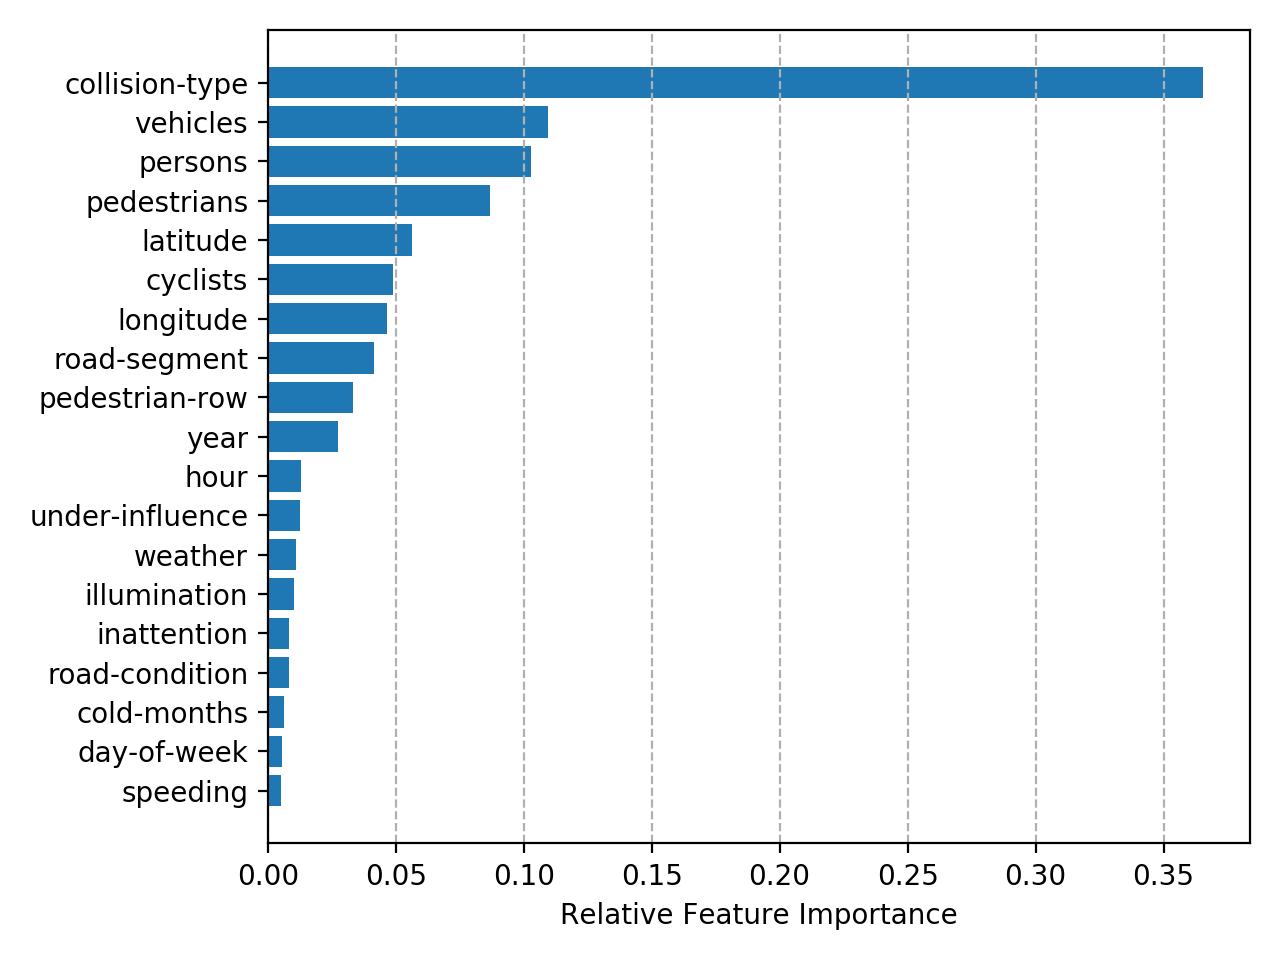

In [1082]:
importance = []
for a in range(len(features.columns.values)):
    importance.append([features.columns.values[a],
                       float(rfc.feature_importances_[a])])
importance.sort(key=lambda x: x[1])
importance_ = np.array(importance).T
n = np.arange(len(importance))

%matplotlib notebook
plt.figure()

plt.grid(axis='x', linestyle='dashed')
plt.barh(importance_[0], np.array(importance_[1], dtype=np.float))
plt.yticks(n, importance_[0])
plt.xlabel('Relative Feature Importance')

plt.tight_layout()
plt.savefig("Report/Feature_Importance.png", dpi=300)
plt.show()

## XGBoost

In [1019]:
import xgboost as xgb

In [1083]:
# determine the scale_pos_weight
neg = collisions['severity'][collisions['severity']==1].count()
pos = collisions['severity'][collisions['severity']==2].count()
scale = neg/pos

In [1036]:
xgbc = xgb.XGBClassifier(criterion="entropy", 
                         objective='binary:logistic',
                         scale_pos_weight=scale)

hyperprms = dict(n_estimators=np.arange(50, 100, 150),
                 max_depth=np.arange(3, 10))

random_search = RandomizedSearchCV(estimator=xgbc,
                                   param_distributions=hyperprms,
                                   scoring='roc_auc',
                                   verbose=1, cv=5, 
                                   n_iter=50, n_jobs=1)

random_result = random_search.fit(X_train, y_train.ravel())

print('Best Score (roc_auc): %s \nBest Hyperparameters: %s' %(random_result.best_score_, 
                                                              random_result.best_params_))

/Users/ninova/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=50. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.4min finished


Best Score (roc_auc): 0.7745936341533001 
Best Hyperparameters: {'n_estimators': 50, 'max_depth': 6}


In [1086]:
xgbc = xgb.XGBClassifier(criterion="entropy", 
                         objective='binary:logistic',
                         scale_pos_weight=scale,
                         n_estimators=50,
                         max_depth=6)

xgbc = xgbc.fit(X_train,y_train.ravel())
xgbc_yhat = xgbc.predict(X_test)
xgbc_yhat_prob = xgbc.predict_proba(X_test)[:, 1]

print("f1-score: %.2f" %(f1_score(y_test, xgbc_yhat)))
print("roc_auc_score: %.2f" %(roc_auc_score(y_test, xgbc_yhat)))
print("""======================================================
Classification report
======================================================\n %s""" %classification_report(y_test, xgbc_yhat))

f1-score: 0.72
roc_auc_score: 0.70
Classification report
               precision    recall  f1-score   support

           1       0.84      0.64      0.72     28574
           2       0.51      0.76      0.61     14086

    accuracy                           0.68     42660
   macro avg       0.67      0.70      0.66     42660
weighted avg       0.73      0.68      0.69     42660



## ROC and Precision-Recall curves
Determine to what extent the prediction results into a true and false positives.

In [1085]:
from sklearn.metrics import precision_recall_curve, roc_curve

<IPython.core.display.Javascript object>


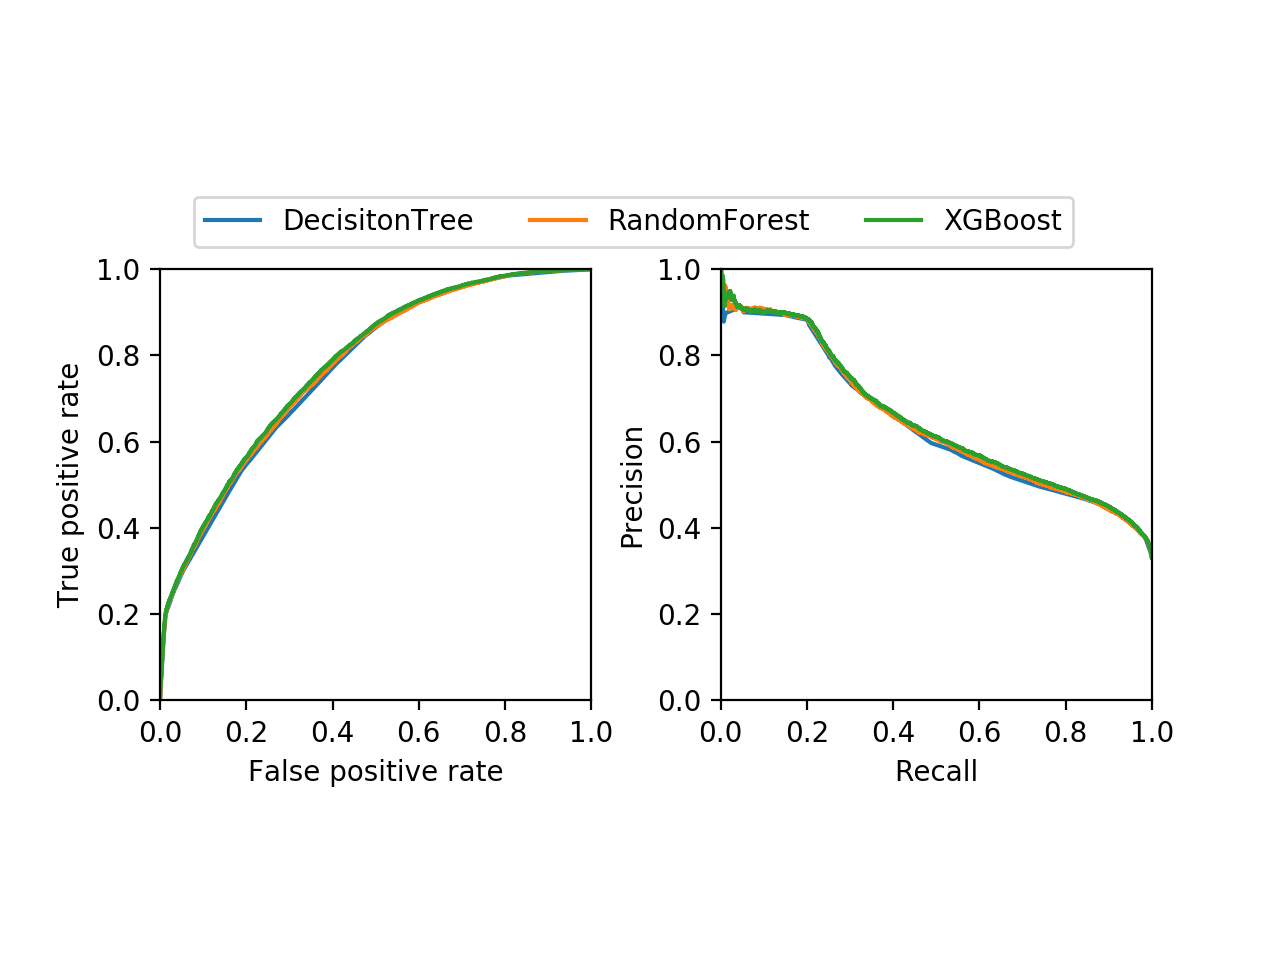

In [1247]:
# extract the false positive and true positive rates for each method
fpr_dtc, tpr_dtc, thr1 = roc_curve(y_test, dtc_yhat_prob, pos_label=2)
fpr_rfc, tpr_rfc, thr2 = roc_curve(y_test, rfc_yhat_prob, pos_label=2)
fpr_xgbc, tpr_xgbc, thr3 = roc_curve(y_test, xgbc_yhat_prob, pos_label=2)

# extract the precision and recall rates for each method
pr_dtc, r_dtc, thr_dtc = precision_recall_curve(y_test, dtc_yhat_prob, pos_label=2)
pr_rfc, r_rfc, thr_dtc = precision_recall_curve(y_test, rfc_yhat_prob, pos_label=2)
pr_xgbc, r_xgbc, thr_xgbc = precision_recall_curve(y_test, xgbc_yhat_prob, pos_label=2)

# plot the results
fig, axs = plt.subplots(1, 2)

axs[0].plot(fpr_dtc, tpr_dtc, label='DecisitonTree')
axs[0].plot(fpr_rfc, tpr_rfc, label='RandomForest')
axs[0].plot(fpr_xgbc, tpr_xgbc, label='XGBoost')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].legend(ncol=3, bbox_to_anchor=(2.15, 1.2))
axs[0].set_aspect(aspect='equal')

axs[1].plot(r_dtc, pr_dtc, label='DecisitonTree')
axs[1].plot(r_rfc, pr_rfc, label='RandomForest')
axs[1].plot(r_xgbc, pr_xgbc, label='XGBoost')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_aspect(aspect='equal')

plt.subplots_adjust(wspace=0.3)
plt.savefig("Report/ROC_PR_curve.png", dpi=300)
plt.show()

Overall, the three methods show similar precision in the class evaluation, where the XGBoost performs marginally better. While a ROC-AUC score of 0.7 is good, it may need to be improved. Indeed, the false positive rate is rather high for high recall, so many injury accidents are  missed when testing and this is not an optimal solution. On a positive note, higher recall values also have a rather high precision. High true positive rate is in fact beneficial, being able to capture also collisions with an increased risk of injuries.

# Conclusion

In conclusion, the present report investigates the predictability of injury collisions as opposed to property-damage ones for the town of Seattle. It is found that the severity of the accident strongly depends on the collisions type. Among the most prone to inflict injury are rear-ended or angled car crashes and accidents with pedestrians and cyclists. The extreme gradient boosting method yielded the highest score of 0.7 for the area of the ROC curve.

Future work includes improving the predictability of the model by considering additional features. As far as the  two-motor vehicle crashes are concerned, it is interesting to see the extent to which they depend on the traffic congestion, measured as velocity needed to leave a certain critical road segment. As far as the accidents with cyclists are concerned, it can be useful to explore the correlation between injury collisions, availability of cycling paths and their visibility to the other participants in the traffic. 